# Hierarchical clustering of microbio data - last updated July 22, 2019

In [1]:
# Import libraries
import matplotlib
%matplotlib inline
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import re
import sklearn
from sklearn import preprocessing
from sklearn import mixture
import scipy

# Step 0: Data Pre-processing

In [2]:
# Import OTU data
df = pd.read_csv(open('df_all.csv','rb'),skip_blank_lines=True)

Text(0.5, 1.0, 'Distribution of Raw OTU Abundance Counts')

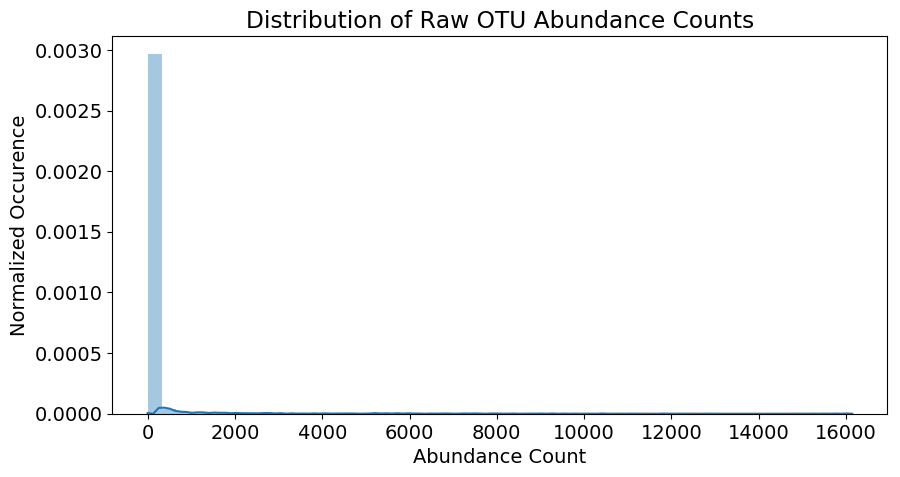

In [3]:
# Make distribution plot of all OTU values
dfvalues = df.loc[:,'Otu8':'Otu819'].values
dfvalues_flat = dfvalues.reshape(-1,1)

fig = plt.figure(figsize=(10,5), dpi=100)
plt.rc("font", size=14)
sns.distplot(dfvalues_flat)
plt.xlabel("Abundance Count")
plt.ylabel("Normalized Occurence")
plt.title("Distribution of Raw OTU Abundance Counts")

In [4]:
dfvalues.shape

(56, 305)

In [5]:
dfvalues_flat.shape

(17080, 1)

In [6]:
# Grab matrix sizes
n_rows = df.values.shape[0]
n_columns_total = df.values.shape[1]
n_columns = n_columns_total - 1 # Subtract off the SampleID column!

## Step 0.1 - Add 1 to all abundance counts, then take log10

In [7]:
# Add 1 to all OTU populations:
df_plus = df.copy()
df_plus.loc[:, 'Otu8':'Otu819'] = df.loc[:, 'Otu8':'Otu819'] + 1
df_plus

,SampleID,Otu8,Otu7,Otu11,Otu4,Otu1,Otu2,Otu62,Otu10,Otu23,...,Otu1719,Otu3945,Otu8953,Otu4344,Otu262,Otu1150,Otu5860,Otu4818,Otu517,Otu819
0,C171,1,1751,3,1308,483,6066,1,1,81,...,7,46,6,5,1,1,1,1,1,1
1,C175,2,4088,3,1191,85,7234,1,1,98,...,12,91,10,6,1,1,1,1,1,1
2,C218,19,5083,42,1991,200,1576,1,1,183,...,3,21,9,4,1,1,1,1,1,1
3,C172,2,2764,20,1189,3782,1209,1,3,102,...,1,5,2,3,1,1,1,1,1,1
4,C115,8,3973,97,4614,4498,1659,10,518,74,...,2,1,1,1,1,1,1,1,1,1
5,C117,2,5106,98,7508,4520,899,3,2562,324,...,1,4,2,1,1,1,1,1,1,1
6,C220,1,4705,894,1575,46,9859,4,960,96,...,1,1,1,1,1,1,1,1,1,1
7,C219,9,6175,70,9255,3020,1075,1,1183,638,...,1,1,1,1,1,1,1,1,1,1
8,C188,1,7937,1605,3788,327,772,1,1893,186,...,1,1,2,1,1,1,1,1,1,1
9,C189,1,7219,633,5074,478,953,1,1607,445,...,1,1,1,1,1,1,1,1,1,1


In [8]:
# Take log10 of all population numbers:
df_log10 = df_plus.copy()
df_log10.loc[:, 'Otu8':'Otu819'] = np.log10(df_plus.loc[:, 'Otu8':'Otu819'])
df_log10

,SampleID,Otu8,Otu7,Otu11,Otu4,Otu1,Otu2,Otu62,Otu10,Otu23,...,Otu1719,Otu3945,Otu8953,Otu4344,Otu262,Otu1150,Otu5860,Otu4818,Otu517,Otu819
0,C171,0.000000,3.243286,0.477121,3.116608,2.683947,3.782902,0.000000,0.000000,1.908485,...,0.845098,1.662758,0.778151,0.698970,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,C175,0.301030,3.611511,0.477121,3.075912,1.929419,3.859379,0.000000,0.000000,1.991226,...,1.079181,1.959041,1.000000,0.778151,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,C218,1.278754,3.706120,1.623249,3.299071,2.301030,3.197556,0.000000,0.000000,2.262451,...,0.477121,1.322219,0.954243,0.602060,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,C172,0.301030,3.441538,1.301030,3.075182,3.577722,3.082426,0.000000,0.477121,2.008600,...,0.000000,0.698970,0.301030,0.477121,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,C115,0.903090,3.599119,1.986772,3.664078,3.653019,3.219846,1.000000,2.714330,1.869232,...,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
5,C117,0.301030,3.708081,1.991226,3.875524,3.655138,2.953760,0.477121,3.408579,2.510545,...,0.000000,0.602060,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
6,C220,0.000000,3.672560,2.951338,3.197281,1.662758,3.993833,0.602060,2.982271,1.982271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
7,C219,0.954243,3.790637,1.845098,3.966376,3.480007,3.031408,0.000000,3.072985,2.804821,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
8,C188,0.000000,3.899656,3.205475,3.578410,2.514548,2.887617,0.000000,3.277151,2.269513,...,0.000000,0.000000,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
9,C189,0.000000,3.858477,2.801404,3.705350,2.679428,2.979093,0.000000,3.206016,2.648360,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


## Step 0.2 - Make distribution plot of log10 counts

Text(0.5, 1.0, 'Distribution of log10 OTU Abundance Counts')

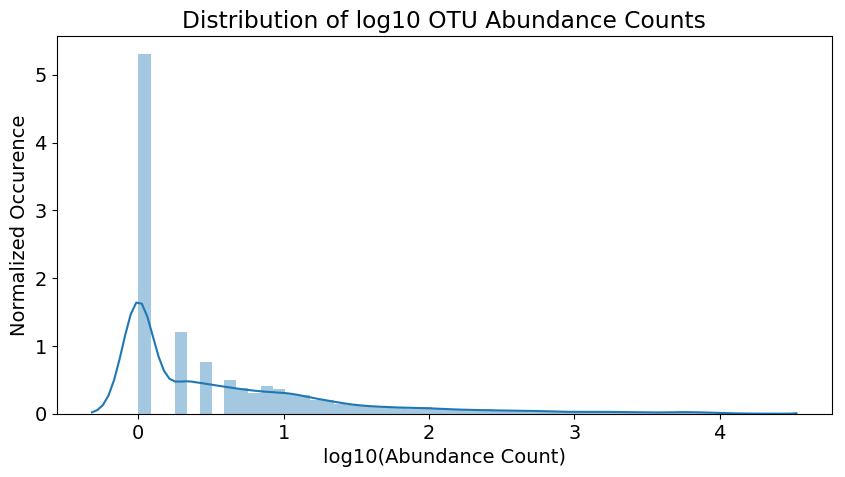

In [9]:
# Now make distribution plot again
df_log10_values = df_log10.loc[:,'Otu8':'Otu819'].values
df_log10_values = df_log10_values.reshape(-1,1)

fig = plt.figure(figsize=(10,5), dpi=100)
plt.rc("font", size=14)
sns.distplot(df_log10_values)
plt.xlabel("log10(Abundance Count)")
plt.ylabel("Normalized Occurence")
plt.title("Distribution of log10 OTU Abundance Counts")

In [10]:
# Remove column means from df_log10 matrix
df_log10_zeromean = df_log10.copy()
column_means = np.mean(df_log10.loc[:, 'Otu8':'Otu819'].values,axis=0)
df_log10_zeromean.loc[:, 'Otu8':'Otu819'] = df_log10.loc[:, 'Otu8':'Otu819'].values - column_means
df_log10_zeromean

,SampleID,Otu8,Otu7,Otu11,Otu4,Otu1,Otu2,Otu62,Otu10,Otu23,...,Otu1719,Otu3945,Otu8953,Otu4344,Otu262,Otu1150,Otu5860,Otu4818,Otu517,Otu819
0,C171,-1.801867,-0.364483,-1.832043,-0.400520,-0.120634,0.327824,-1.122893,-2.585589,-0.312965,...,0.743426,1.384329,0.643059,0.551274,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
1,C175,-1.500837,0.003742,-1.832043,-0.441216,-0.875162,0.404301,-1.122893,-2.585589,-0.230224,...,0.977509,1.680612,0.864908,0.630455,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
2,C218,-0.523113,0.098351,-0.685915,-0.218057,-0.503551,-0.257522,-1.122893,-2.585589,0.041001,...,0.375449,1.043790,0.819150,0.454364,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
3,C172,-1.500837,-0.166231,-1.008135,-0.441946,0.773140,-0.372652,-1.122893,-2.108467,-0.212850,...,-0.101672,0.420541,0.165938,0.329425,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
4,C115,-0.898777,-0.008650,-0.322393,0.146949,0.848438,-0.235232,-0.122893,0.128741,-0.352219,...,0.199358,-0.278429,-0.135092,-0.147696,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
5,C117,-1.500837,0.100312,-0.317938,0.358396,0.850557,-0.501318,-0.645772,0.822990,0.289095,...,-0.101672,0.323631,0.165938,-0.147696,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
6,C220,-1.801867,0.064791,0.642173,-0.319848,-1.141823,0.538755,-0.520833,0.396682,-0.239179,...,-0.101672,-0.278429,-0.135092,-0.147696,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
7,C219,-0.847624,0.182868,-0.464066,0.449248,0.675426,-0.423669,-1.122893,0.487396,0.583370,...,-0.101672,-0.278429,-0.135092,-0.147696,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
8,C188,-1.801867,0.291888,0.896311,0.061282,-0.290033,-0.567461,-1.122893,0.691562,0.048063,...,-0.101672,-0.278429,0.165938,-0.147696,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339
9,C189,-1.801867,0.250708,0.492239,0.188222,-0.125153,-0.475985,-1.122893,0.620427,0.426910,...,-0.101672,-0.278429,-0.135092,-0.147696,-0.289170,-0.235007,-0.130718,-0.117956,-0.040273,-0.030339


In [11]:
# Sanity check to ensure new matrix truly has zero column means:
column_means_zeromean = df_log10_zeromean.mean(axis=0).values.reshape((-1,1)).T
np.sum(column_means_zeromean) # Should be virtually zero

-4.653519633127498e-15

## Step 0.3 - Import association values from netassoc (these values were calculated from the df_log10_zeromean file)

** Note: The netassoc (https://cran.r-project.org/web/packages/netassoc/index.html) results were computed externally (i.e. not within this notebook!)

In [13]:
# Import netassoc output
netassoc_read = pd.read_csv(open('netassoc.csv','rb'),index_col=0,skip_blank_lines=True)
netassoc = netassoc_read.copy()

# First fill NA values, to prevent operating on NA values
netassoc_read = netassoc_read.fillna(0)

# Find max, min of netassoc associations
A = netassoc_read.values
A_max = np.max(A)
A_min = np.min(A)
A_avg = np.mean((A_max,A_min))

# Set NA values to intermediate value between max and min
netassoc = netassoc.fillna(A_avg)
netassoc.shape # Sanity check on dimensions

(305, 305)

In [14]:
# Sanity check: average netassoc value?
A_avg

17.231892164999998

In [15]:
# Sanity check: netassoc association matrix itself
netassoc

,Otu8,Otu7,Otu11,Otu4,Otu1,Otu2,Otu62,Otu10,Otu23,Otu141,...,Otu1719,Otu3945,Otu8953,Otu4344,Otu262,Otu1150,Otu5860,Otu4818,Otu517,Otu819
Otu8,17.231892,7.589421,17.231892,7.910329,17.231892,-4.983631,-4.494113,-2.842006,17.231892,17.231892,...,17.231892,17.231892,17.231892,17.231892,-7.821079,-4.203886,17.231892,17.231892,17.231892,17.231892
Otu7,7.589421,17.231892,17.231892,7.478538,-7.742092,-7.769532,-4.114350,-3.908914,-3.031073,17.231892,...,17.231892,17.231892,17.231892,17.231892,-3.444960,-4.319366,17.231892,17.231892,-5.786582,-5.103359
Otu11,17.231892,17.231892,17.231892,-3.150644,6.209110,-4.907444,17.231892,17.231892,5.412472,-7.756276,...,-3.683830,17.231892,17.231892,17.231892,-5.864870,17.231892,17.231892,-5.030755,-3.130072,-3.836666
Otu4,7.910329,7.478538,-3.150644,17.231892,17.231892,-11.390788,-6.123702,-4.533159,17.231892,17.231892,...,17.231892,17.231892,17.231892,17.231892,-8.176091,-6.617585,17.231892,3.640712,17.231892,17.231892
Otu1,17.231892,-7.742092,6.209110,17.231892,17.231892,-9.791333,-5.226319,4.984513,17.231892,-6.152976,...,-7.041877,-3.838659,-4.745144,-15.767335,-12.418007,17.231892,7.337649,10.813848,-6.763488,-8.423350
Otu2,-4.983631,-7.769532,-4.907444,-11.390788,-9.791333,17.231892,11.139155,9.236524,-5.424729,12.883324,...,17.231892,17.231892,17.231892,17.231892,15.914944,17.231892,5.062533,17.231892,17.231892,17.231892
Otu62,-4.494113,-4.114350,17.231892,-6.123702,-5.226319,11.139155,17.231892,11.269241,17.231892,-14.791925,...,-5.204573,-3.229484,17.231892,17.231892,-7.263759,-2.889895,17.231892,17.231892,17.231892,17.231892
Otu10,-2.842006,-3.908914,17.231892,-4.533159,4.984513,9.236524,11.269241,17.231892,17.231892,-9.747071,...,-4.535853,17.231892,17.231892,-7.262676,5.743464,17.231892,17.231892,-3.057102,-5.974035,-5.491326
Otu23,17.231892,-3.031073,5.412472,17.231892,17.231892,-5.424729,17.231892,17.231892,17.231892,17.231892,...,-5.654079,-5.789697,-5.001242,-5.027782,17.231892,17.231892,17.231892,17.231892,17.231892,17.231892
Otu141,17.231892,17.231892,-7.756276,17.231892,-6.152976,12.883324,-14.791925,-9.747071,17.231892,17.231892,...,-5.226099,17.231892,17.231892,17.231892,17.231892,-4.972457,17.231892,17.231892,-5.955376,-6.018600


## Step 0.4 - Turn netassoc association into normalized distance using formula:

$dist = \frac{A_{max}-A}{A_{max}-A_{min}}$

Note that this produces distance values between 0 and 1.

In [16]:
# Turn correlation values into a distance matrix
A_max = np.max(netassoc.values)
A_min = np.min(netassoc.values)
netassoc_dist = (A_max - A)/(A_max - A_min)

# Sanity check
print(np.min(netassoc_dist))
print(np.max(netassoc_dist))

0.0
1.0


In [17]:
# Set diagonal elements to zero for squareform function to work properly:
np.fill_diagonal(netassoc_dist,0,wrap=False)

# Extract upper triangular elements (without the zeroes) of p-distance matrix:
from scipy.spatial.distance import squareform
p_dist_compressed = squareform(netassoc_dist) # Use built-in function instead

Text(0.5, 1.0, 'Distribution of 0-1 Associations')

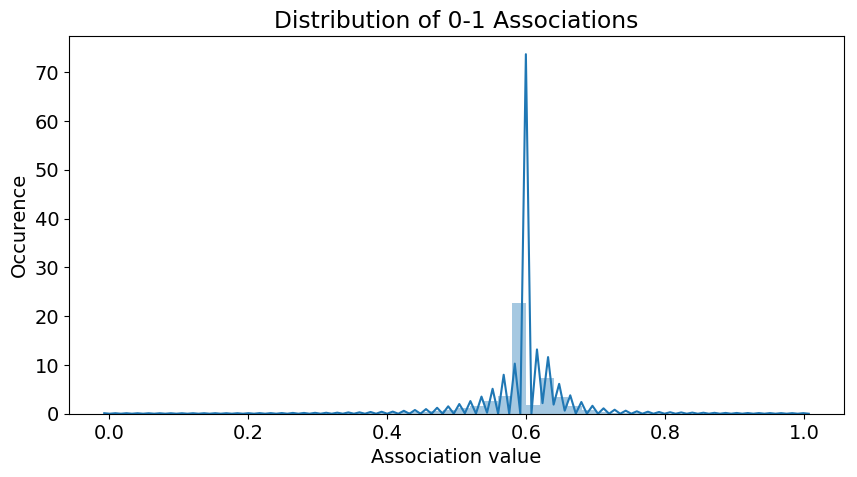

In [18]:
# Make a histogram plot of the netassoc values

p_dist_compressed

fig = plt.figure(figsize=(10,5), dpi=100)
plt.rc("font", size=14)
sns.distplot(p_dist_compressed)
plt.xlabel("Association value")
plt.ylabel("Occurence")
plt.title("Distribution of 0-1 Associations")

Text(0.5, 1.0, 'Distribution of Coalitions')

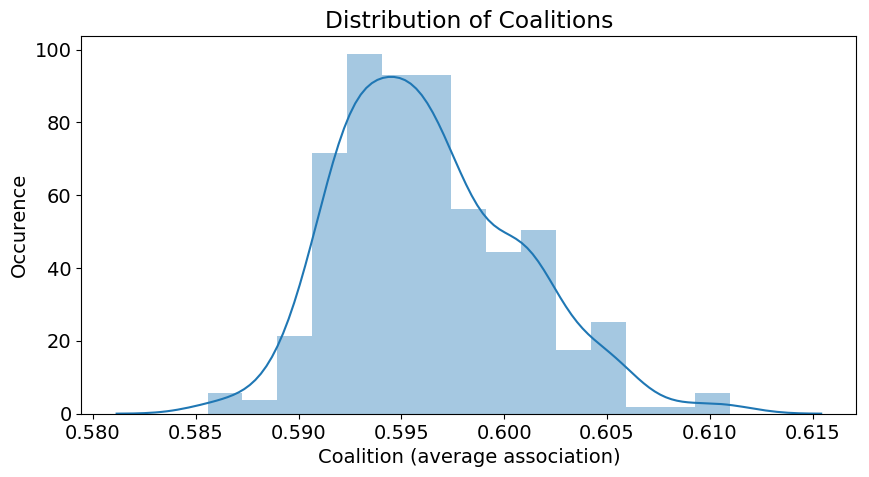

In [19]:
# For each OTU, calculate COALITION association (mean association value with all other OTUs)
# This is just for more visualization purposes
n_rows = netassoc_dist.shape[0]

coalitions = []
for i in range(0,n_rows):
    rel_array = np.delete(netassoc_dist[i],i,0)
    coalitions.append(np.mean(rel_array))
coalitions = np.asarray(coalitions)

# Make histogram of coalitions
fig = plt.figure(figsize=(10,5), dpi=100)
plt.rc("font", size=14)
sns.distplot(coalitions)
plt.xlabel("Coalition (average association)")
plt.ylabel("Occurence")
plt.title("Distribution of Coalitions")

In [20]:
# What does the coalition matrix look like?
coalitions

array([0.59935592, 0.59472272, 0.60063494, 0.5976309 , 0.60584718,
       0.60220252, 0.60065702, 0.60078857, 0.59231177, 0.60502708,
       0.59741923, 0.59245889, 0.59546751, 0.60062079, 0.59488249,
       0.59277847, 0.59627292, 0.60319611, 0.59288583, 0.5931485 ,
       0.59505518, 0.59577026, 0.59217159, 0.60117995, 0.59615691,
       0.59262186, 0.60520124, 0.59485415, 0.59477678, 0.59352808,
       0.60247398, 0.59498372, 0.59235039, 0.59804716, 0.60086461,
       0.59787308, 0.59494347, 0.60433635, 0.58606703, 0.59957038,
       0.59660363, 0.60078725, 0.59838466, 0.60540023, 0.59924007,
       0.59615225, 0.59160792, 0.58960059, 0.59848251, 0.59493236,
       0.60400342, 0.59067449, 0.59322953, 0.59675354, 0.60221569,
       0.59102044, 0.59757549, 0.59180988, 0.59763666, 0.60099317,
       0.60569193, 0.60046374, 0.59688107, 0.59730505, 0.5920718 ,
       0.60819866, 0.59496538, 0.60320141, 0.59740916, 0.5958225 ,
       0.59609754, 0.5932705 , 0.59049962, 0.60492715, 0.59382

## Step 1: Silhouette analysis to determine optimal number of clusters
Note: This is assuming a UPGMA clustering, which was determined to be the "best" (better than WARD, complete, or single linkage)

(array([-0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15]),
 <a list of 6 Text yticklabel objects>)

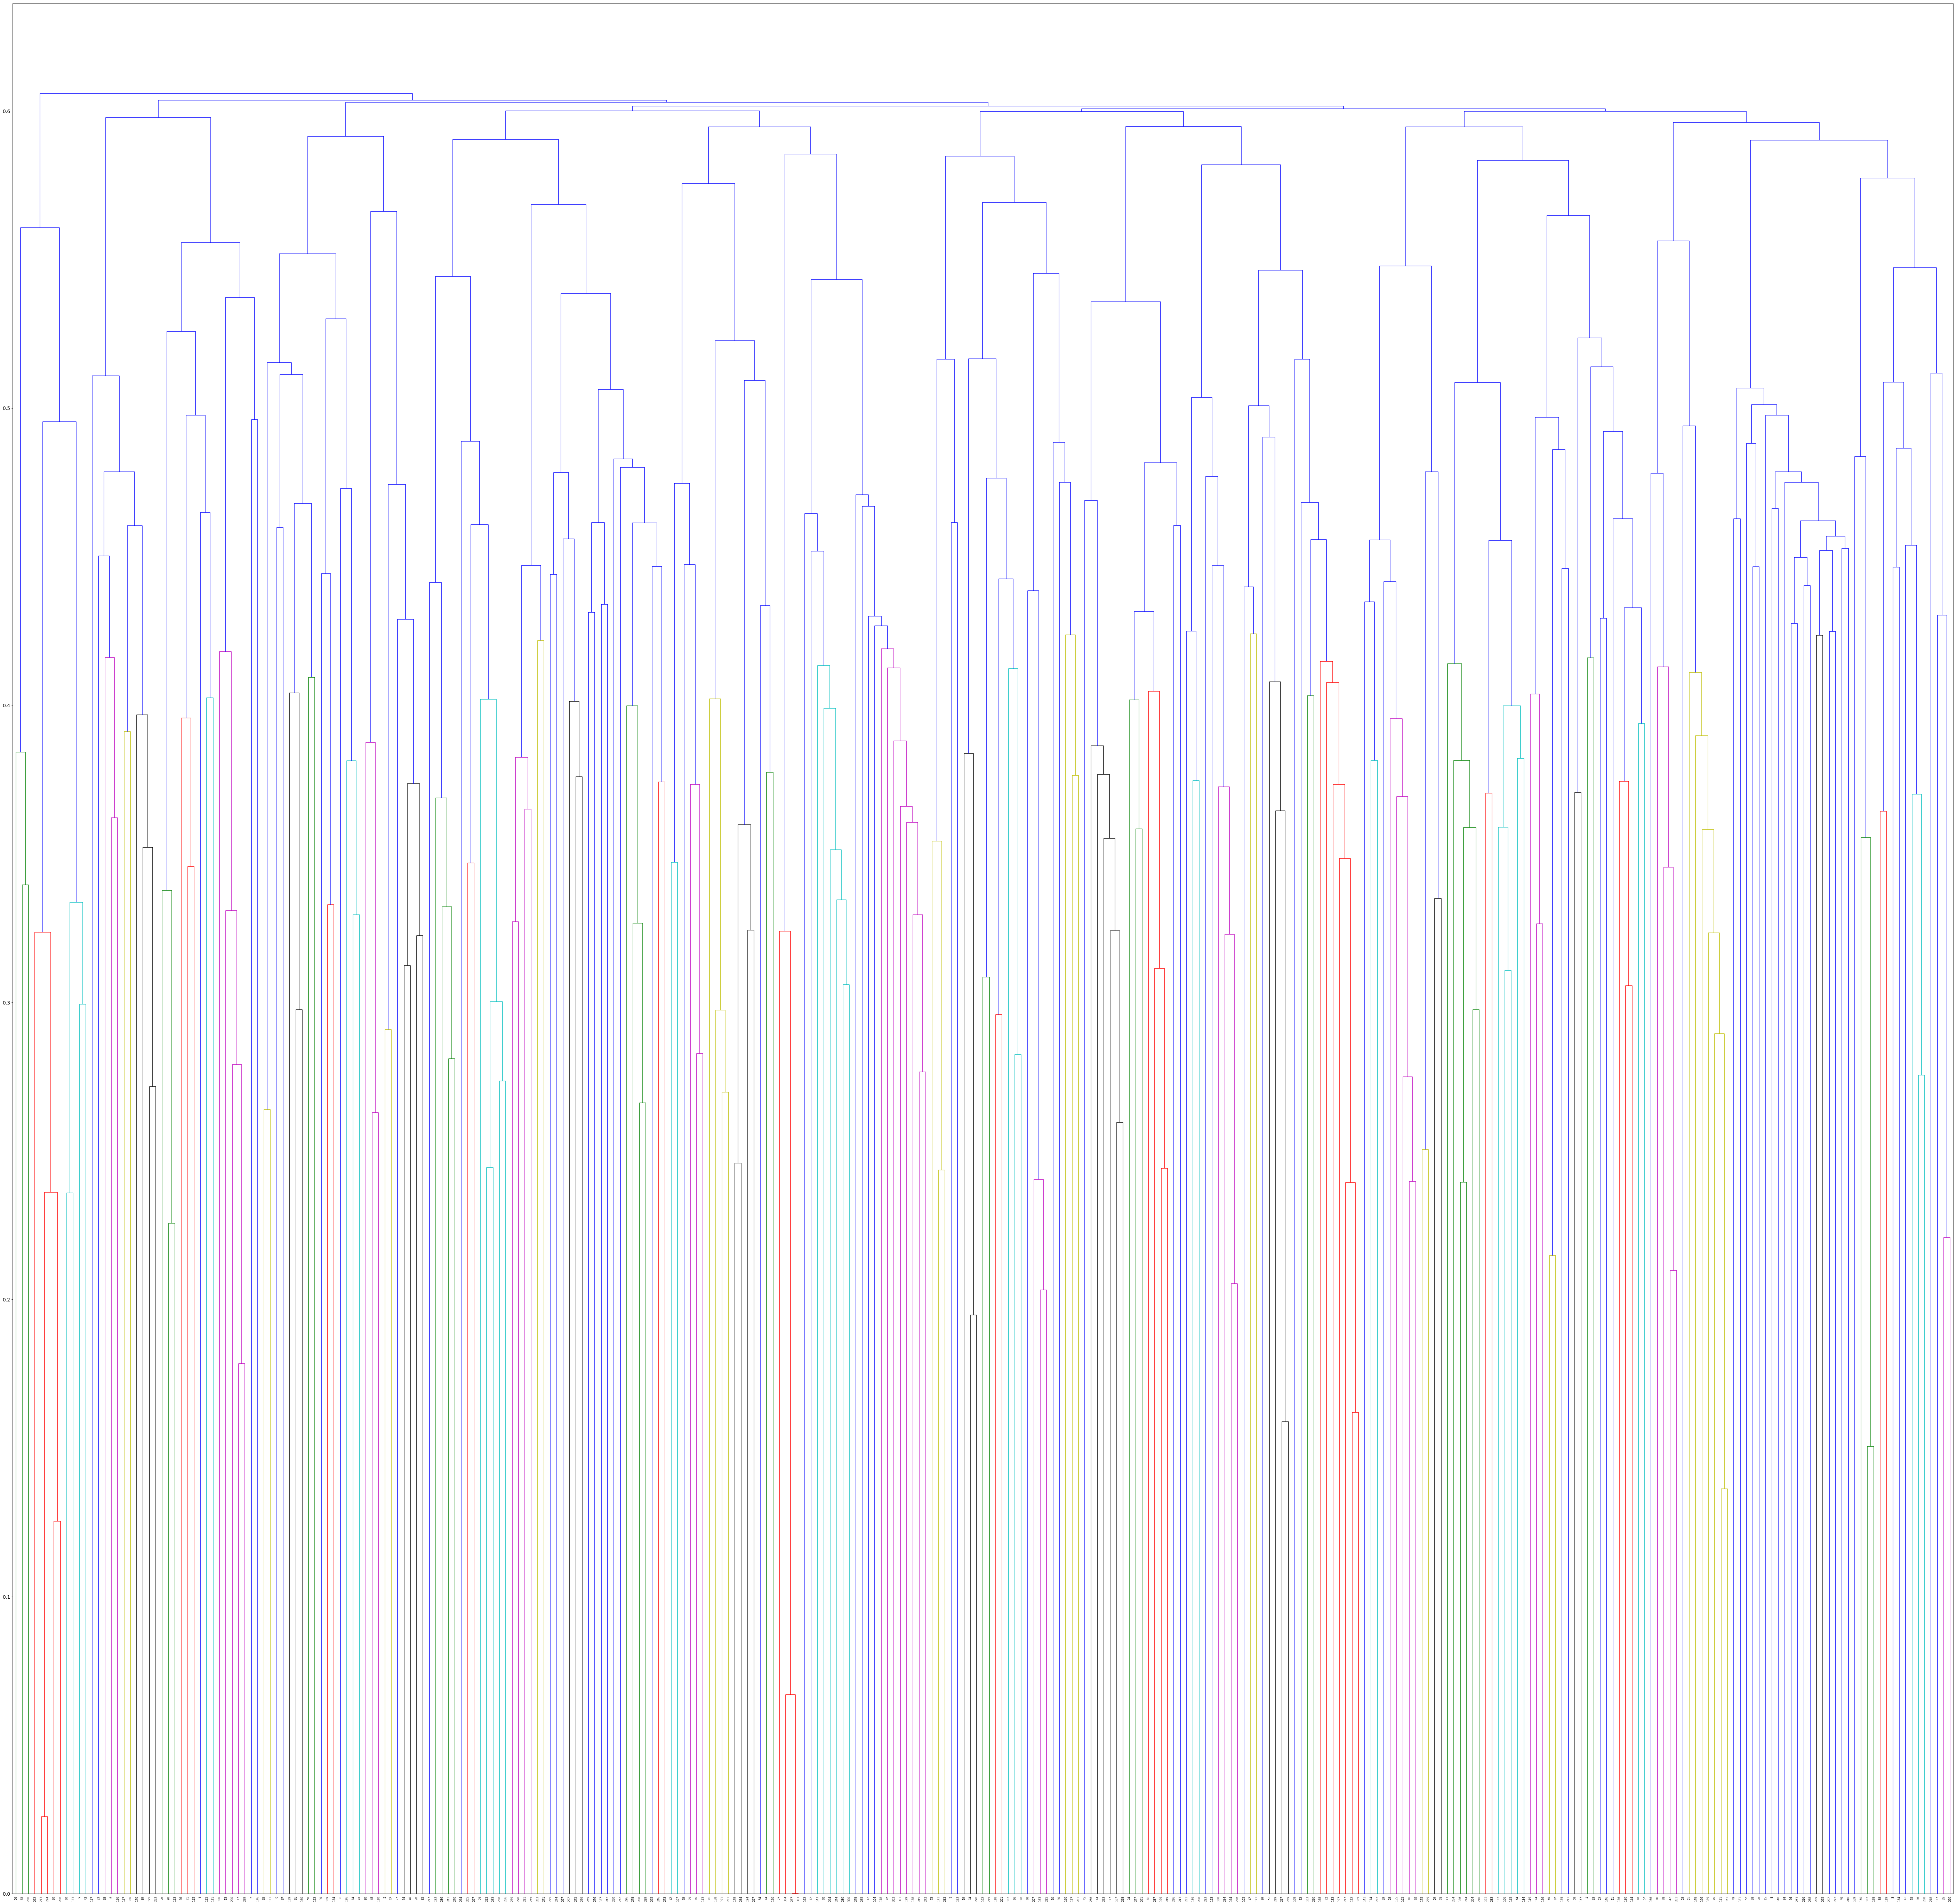

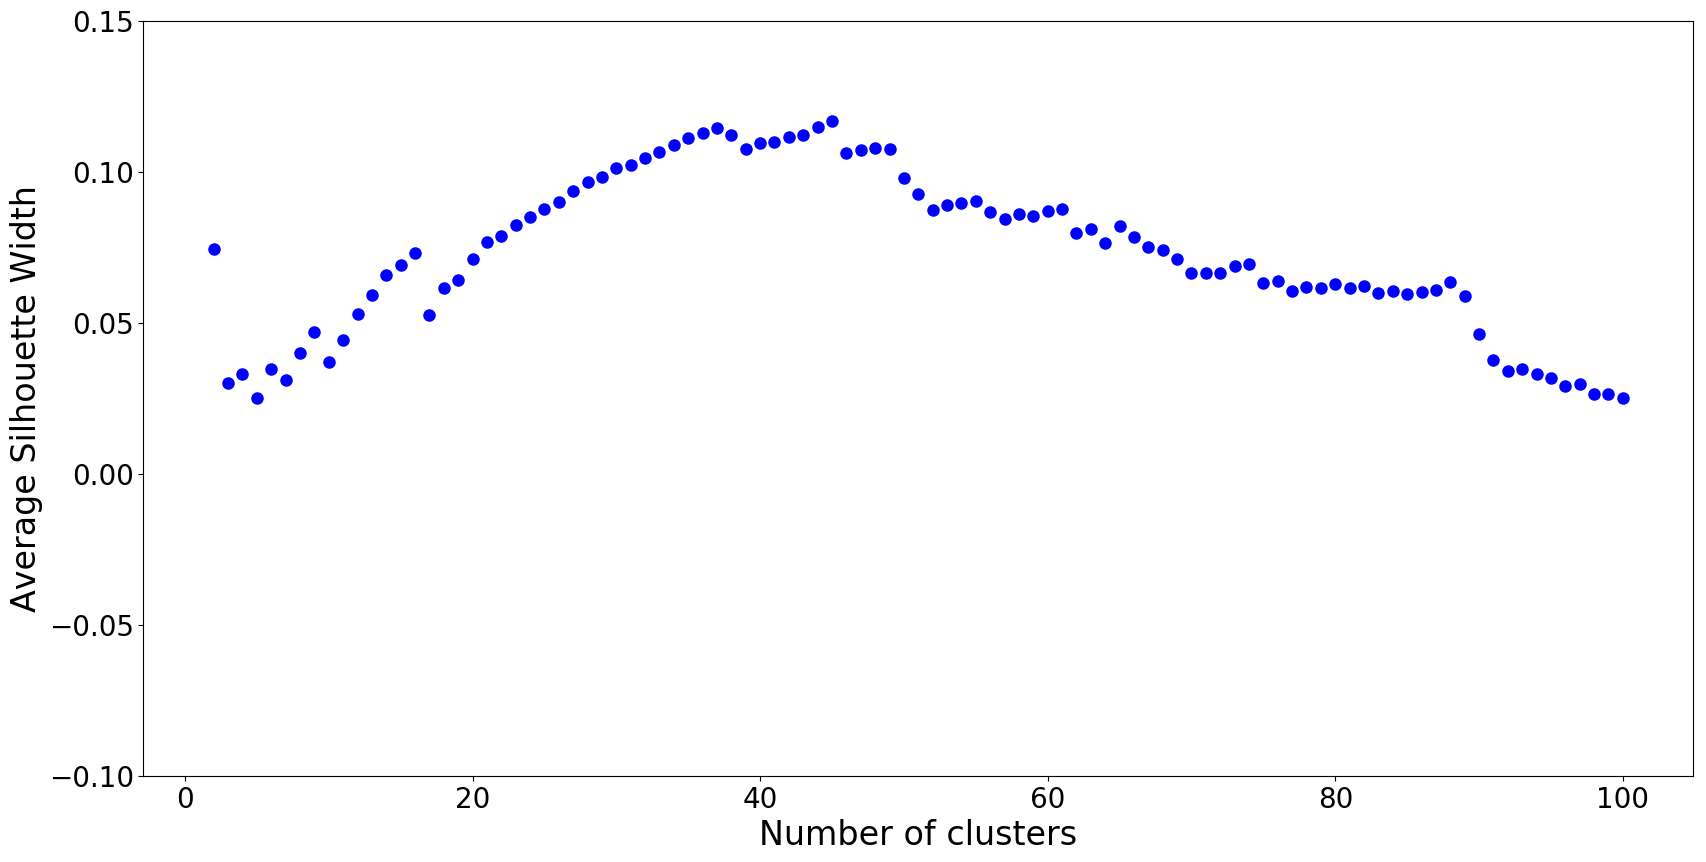

In [21]:
# Silhouette analysis
from scipy.cluster import hierarchy
plt.figure(figsize=(100,100))
p_clustering_matrix = hierarchy.linkage(p_dist_compressed,method='average')
p_dn = hierarchy.dendrogram(p_clustering_matrix,
                            leaf_rotation=90,
                            leaf_font_size=8)

# Silhouette analysis
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Pick "best" clustering based on Silhouette analysis
num_clusters_max = 100
sil_labels = np.linspace(2,num_clusters_max,num_clusters_max-1)
sil_labels = np.reshape(sil_labels,(-1,1))
sil_avg = np.zeros((num_clusters_max-1,1))
for num_clusters in range(2,num_clusters_max+1):
    cluster_nodes = hierarchy.fcluster(p_clustering_matrix, num_clusters, criterion="maxclust")
    sil_avg_single = silhouette_score(netassoc_dist, cluster_nodes, metric='euclidean')
    sil_avg[num_clusters-2] = sil_avg_single

sil_avg = np.append(sil_labels,sil_avg,axis=1)

fig = plt.figure(figsize=(20,10), dpi=100)
plt.rc("font", size=14)
plt.plot(sil_avg[:,0],sil_avg[:,1],'.',markersize=16,color='blue')
plt.ylim(-0.1,0.15)
plt.xlabel("Number of clusters",fontsize=24)
plt.ylabel("Average Silhouette Width",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title("Silhouette analysis to determine optimal number of UPGMA clusters")

### Step 1.1: Perform distance cutoff based on Sanderson et al's RCLUS paper (2006)

(array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12]),
 <a list of 6 Text yticklabel objects>)

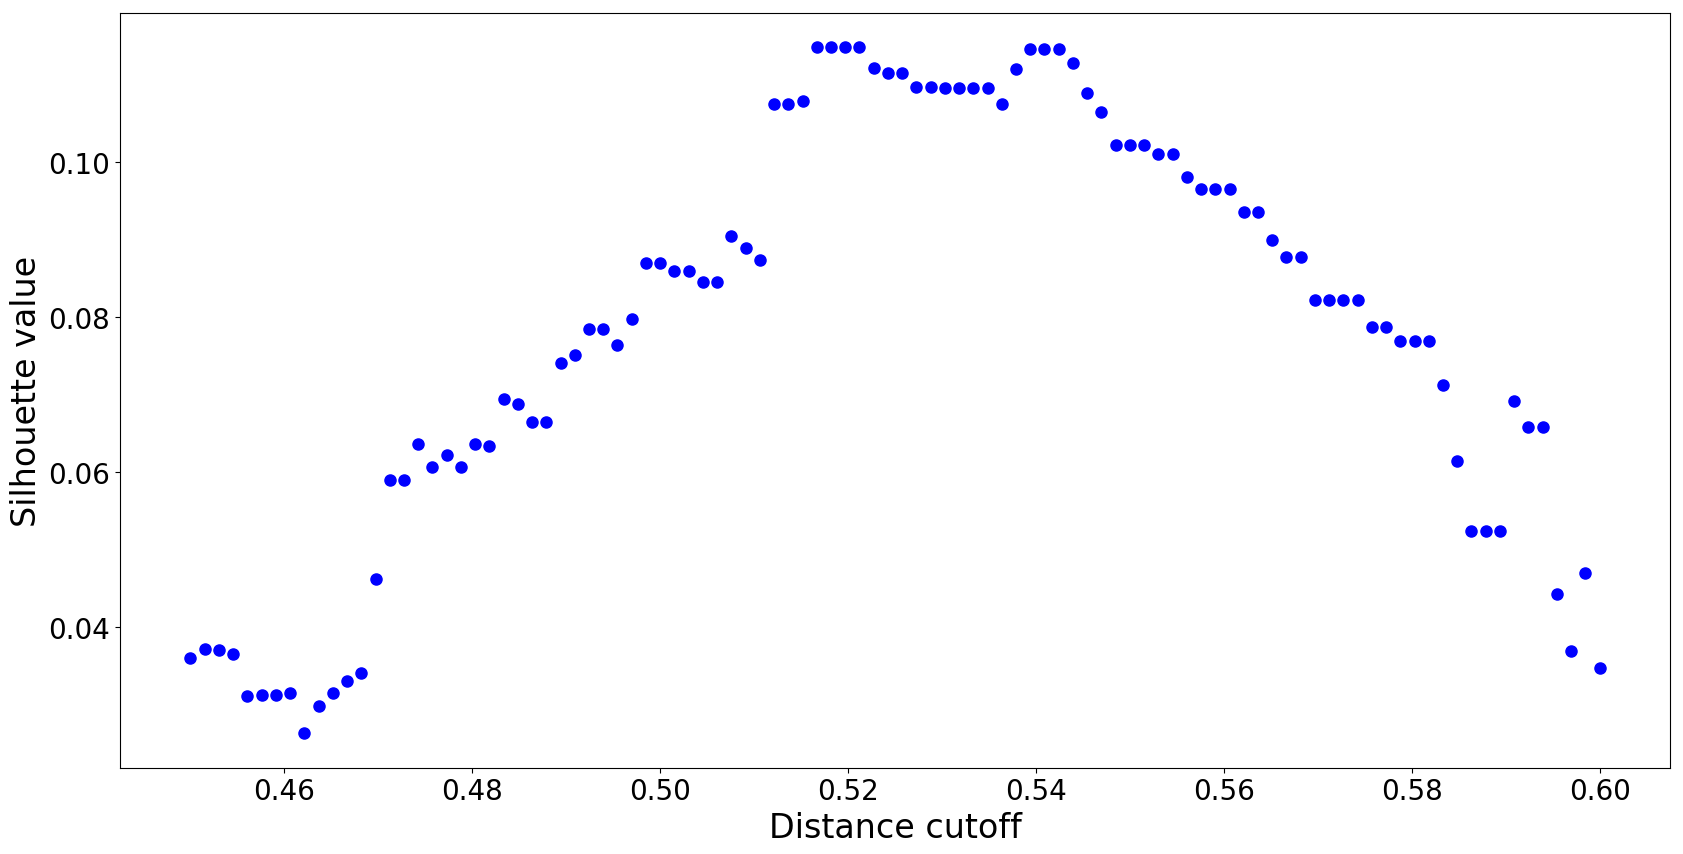

In [22]:
# Pick "best" distance cutoff based on Silhouette analysis
min_cutoff = 0.45
max_cutoff = 0.6
num_points = 100
dist_cutoff = np.linspace(min_cutoff,max_cutoff,num_points)
sil_cutoff = []

for i in range(0,dist_cutoff.shape[0]):
    cutoff = dist_cutoff[i]
    nodes_dist_cutoff = hierarchy.fcluster(p_clustering_matrix, cutoff, criterion="distance")

    # Calculate Silhouette value for this cutoff
    sil_value = silhouette_score(netassoc_dist, nodes_dist_cutoff, metric='euclidean')
    sil_cutoff.append(sil_value)

sil_cutoff = np.asarray(sil_cutoff)
fig = plt.figure(figsize=(20,10), dpi=100)
plt.rc("font", size=20)
plt.plot(dist_cutoff,sil_cutoff,'.',markersize=16,color='blue')
# plt.ylim(-0.1,0.15)
plt.xlabel("Distance cutoff", fontsize=24)
plt.ylabel("Silhouette value", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title("Silhouette analysis to determine optimal distance cutoff")

In [23]:
# Form flat clusters from UPGMA, based on distance-cutoff
dist_cutoff = 0.54
nodes_dist_cutoff = hierarchy.fcluster(p_clustering_matrix, dist_cutoff, criterion="distance")

# Calculate Silhouette value for this cutoff
sil_cutoff = silhouette_score(netassoc_dist, nodes_dist_cutoff, metric='euclidean')

print(nodes_dist_cutoff)
print(np.max(nodes_dist_cutoff))
print(sil_cutoff)

[ 6  4  9 36 31  5  3 19 34  2 22 31 17  5  7 34 27  5 31 20  9 33 31  3
 23 11  4 16 27 27  2  7 26 31  9 37  4  9 34  7  9 36 14  2 15 23 34 25
  8 34  6 25 34 33 15 36  1 31 31 28  2  6 27  3 29  6 20  6 21 30 17  4
 26 19 20 28 34  9 32 14  8 23  9  1 34 14 32 30 36  3 22 15 14  7 34 33
 36 18  4 25  5 29 20 26 18 25 29 14 26  7  8 33 18 14 23  4  3  3 20 36
 15 25  6  4 30  4  7 23 20 18 31  6 26  2  7 30 31 37 18  6 34 27 32 17
 31 29 31  3 33 30 35  4 29 24 36 27 30 31 15 24  6 33 17 21 24 27 32 23
 26 35  3 19 26 29 27 28  5 22 18 15  3 34 35 19 29 26 29 13 24 33 22 15
 20 10 15  3 33 26 35 23  5 20 34 12 29 11  2 21 24 34 29 30 11  2 29 20
 34 26 37 25 26 12 34 24  2 13 24 25 23 28  1 24 27 29 24 21 23 23 11 12
 34 10 13 23 17 18 13 23 18 23 13 15 13  3 29 12 11 15 36 25 37 32  2 34
 11 34 23 13 34 13 10 12 18 13 13 13 13 10 13 13 17 22 19 11 15 18 10 16
 13 13 20 23 13 23 17 13 13 11 12  5 17 18 18 16 16]
37
0.11453254689285876


In [24]:
# Grab original OTU labels
OTU_columns = df_plus.loc[:, 'Otu8':'Otu819'].columns

# Match each OTU to its corresponding cluster
cluster_df_UPGMA = pd.DataFrame(data = nodes_dist_cutoff.reshape(1,-1),columns = OTU_columns)

# Create a tally of all the OTUs for each cluster
cluster_labels = np.unique(nodes_dist_cutoff)
cluster_tally=pd.DataFrame(index=cluster_labels,columns=np.linspace(1,305,305).astype(int))

for i in cluster_labels:
    members = []
    for j in OTU_columns:
        if cluster_df_UPGMA.loc[:,j].values == i:
            members.append(j)
    cluster_tally.values[i-1,0:len(members)] = members
cluster_tally = cluster_tally.dropna(axis='columns',how='all')

# Output as csv file
cluster_tally.to_csv('cluster_tally.csv')

# Also export the cluster-label dataframe
cluster_df_UPGMA.to_pickle("UPGMA_labels.pkl")

In [25]:
cluster_df_UPGMA

,Otu8,Otu7,Otu11,Otu4,Otu1,Otu2,Otu62,Otu10,Otu23,Otu141,...,Otu1719,Otu3945,Otu8953,Otu4344,Otu262,Otu1150,Otu5860,Otu4818,Otu517,Otu819
0,6,4,9,36,31,5,3,19,34,2,...,13,13,11,12,5,17,18,18,16,16


In [26]:
# Sanity checks on whether tally file makes sense:
np.sum(np.equal(nodes_dist_cutoff,9))

7

In [27]:
## Find cluster centroids
df_log_relevant = df_log10.loc[:,'Otu8':'Otu819']
num_samples = df_log_relevant.shape[0]
num_clusters = np.max(nodes_dist_cutoff)
closest_OTUs = []

# First determine the centroid coordinates for all clusters
centroids = np.zeros((num_samples,num_clusters))
for i in range(0,num_clusters):
    members = cluster_tally.loc[[i+1]].dropna(axis=1).values[0].tolist()
    
    # First determine the centroid coordinates for all clusters
    member_coords = df_log_relevant[members].values
    centroid_coords = np.average(member_coords,axis=1)
    centroids[:,i] = centroid_coords
    
    # Within each cluster, determine the OTU closest to centroid (in terms of Euclidean distance) 
    dist_matrix = scipy.spatial.distance_matrix(centroid_coords.reshape(1,-1),member_coords.T)
    closest_index = np.argmin(dist_matrix)
    closest_OTU = members[closest_index]
    closest_OTUs.append(np.asarray(closest_OTU).tolist())

In [28]:
np.asarray(closest_OTUs)
# Export the representative OTU labels
np.save("closest_OTUs.npy",np.asarray(closest_OTUs))

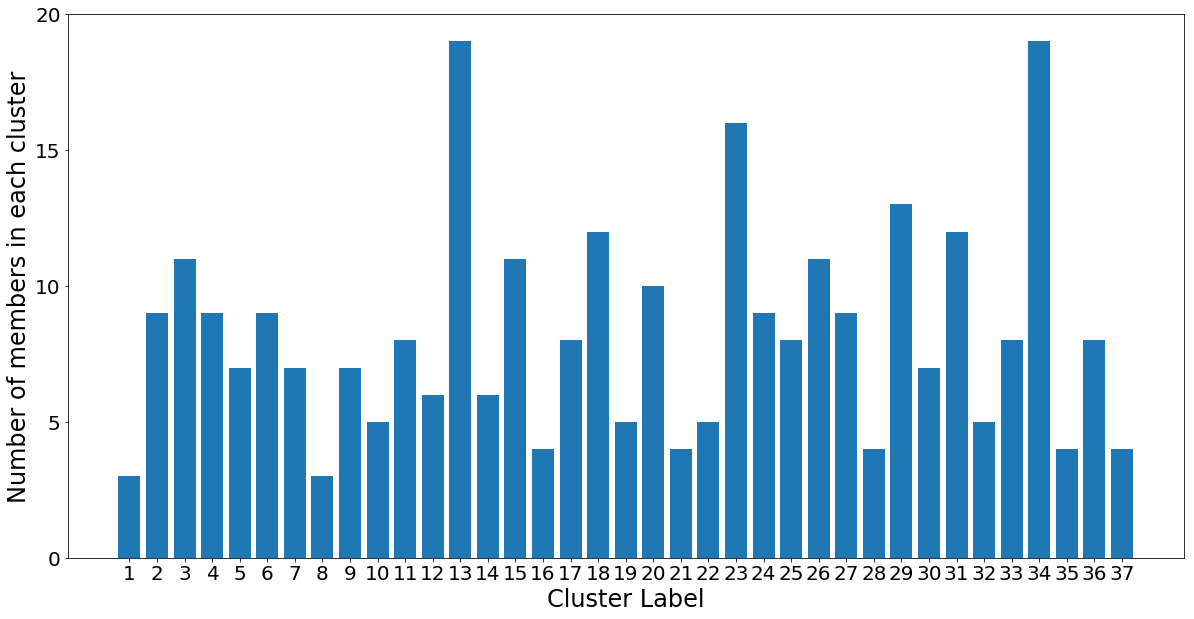

In [29]:
## Histogram 1: Show how many members are in each cluster
num_clusters = np.max(cluster_labels)
num_members_array = []
for i in cluster_tally.index:
    num_members = cluster_tally.loc[[i],:].columns.shape-cluster_tally.loc[[i],:].isnull().sum().sum()
    num_members_array.append(num_members)
num_members_array = np.asarray(num_members_array)

plt.figure(figsize=(20,10))
plt.rc("font", size=20)
plt.bar(np.linspace(1,np.max(cluster_labels),np.max(cluster_labels)).astype(int),num_members_array.reshape(-1))
plt.xticks(np.arange(1,np.max(cluster_labels)+1,1))
plt.xlabel("Cluster Label",fontsize=24)
plt.ylabel("Number of members in each cluster",fontsize=24)
plt.yticks(np.arange(0,25,step=5),fontsize=20)
#plt.title("Cluster population histogram")
plt.show()

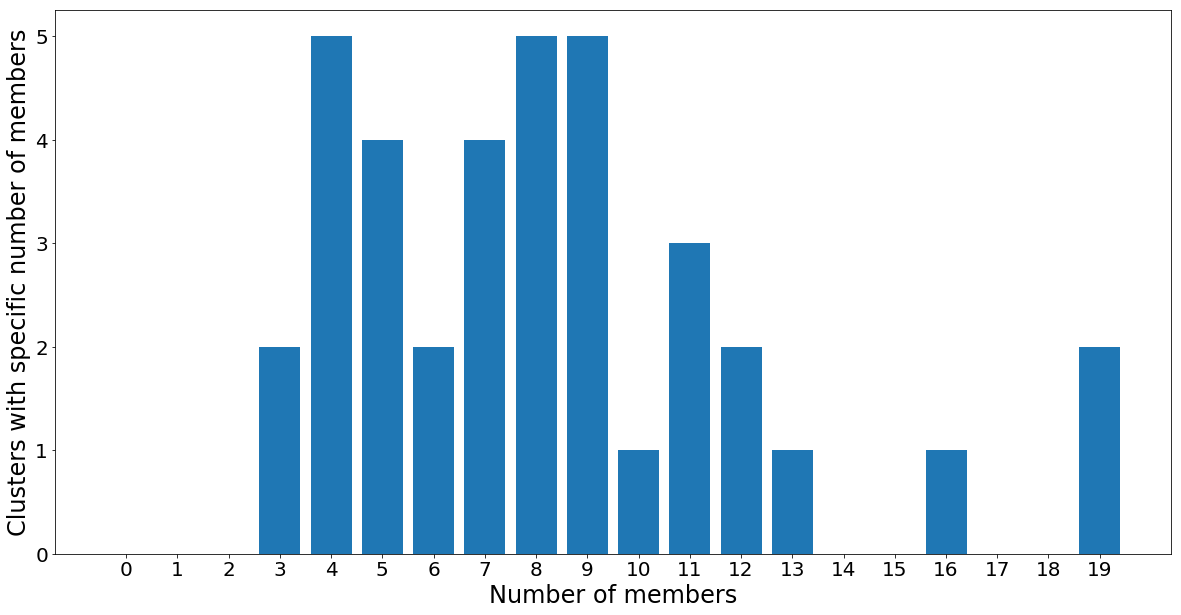

In [30]:
## Histogram 2: Show how many clusters have 1 member, 2 members, etc.
num_clusters_array = []
for i in range(0,np.max(num_members_array)+1):
    sum_term = 0
    for j in range(0,num_members_array.shape[0]):
        if num_members_array[j] == i:
            sum_term += 1
    num_clusters_array.append(sum_term)
num_clusters_array = np.asarray(num_clusters_array)

plt.figure(figsize=(20,10))
plt.rc("font", size=20)
plt.bar(np.linspace(0,np.max(num_members_array),np.max(num_members_array)+1).astype(int),num_clusters_array.reshape(-1)) 
plt.xticks(np.arange(0,np.max(num_members_array)+1,1))
plt.yticks(np.arange(0,6,step=1),fontsize=20)
plt.xlabel("Number of members",fontsize=24)
plt.ylabel("Clusters with specific number of members",fontsize=24)
#plt.title("Cluster membership histogram")
plt.show()

# Step 2: Determining the optimal clustering method

### Step 2.1: Try UPGMA first

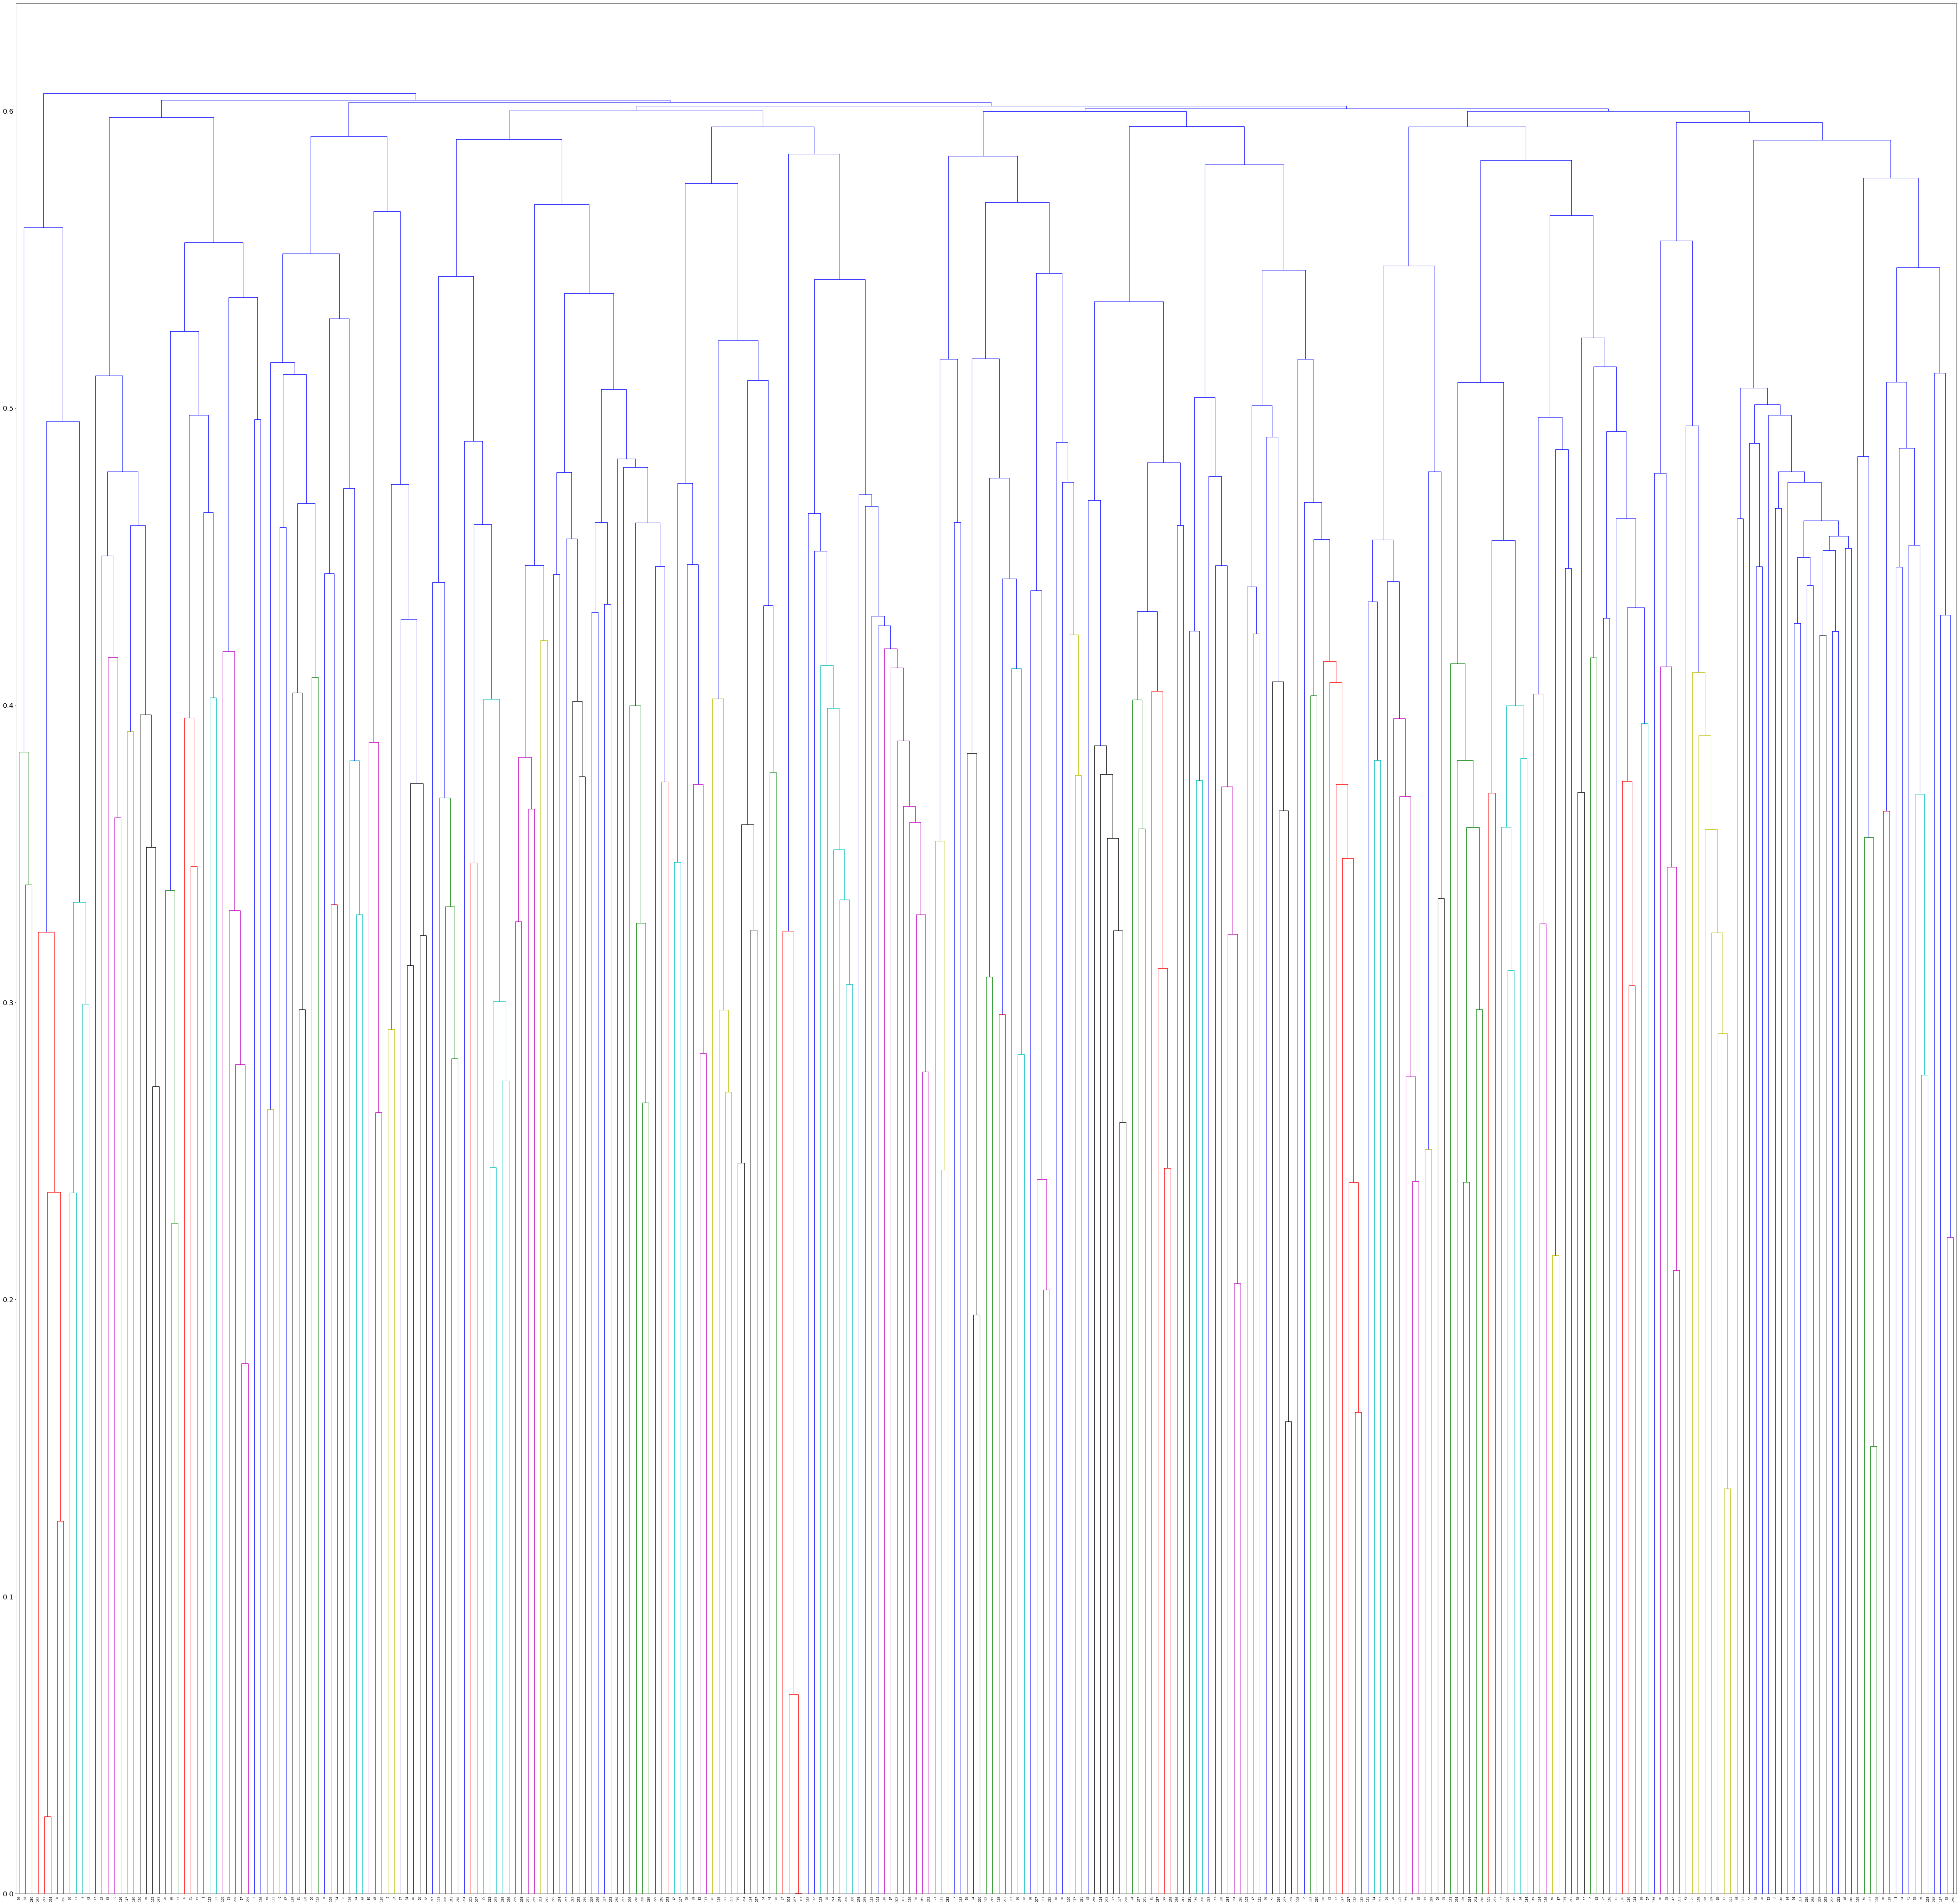

In [31]:
# Perform hierarchical clustering analysis using p-distance values:
from scipy.cluster import hierarchy
plt.figure(figsize=(100,100))
p_clustering_matrix = hierarchy.average(p_dist_compressed)
p_dn = hierarchy.dendrogram(p_clustering_matrix,
                            leaf_rotation=90,
                            leaf_font_size=8)

In [32]:
# Grab dendrogram labels (from left to right) and match them to OTU IDs:
OTU_columns = df_plus.loc[:, 'Otu8':'Otu819'].columns.values.reshape(-1,1)
n_OTUs = OTU_columns.shape[0]
numeric_labels = np.linspace(1,n_OTUs,num=n_OTUs).astype(int).reshape(-1,1)
labels = np.concatenate((OTU_columns,numeric_labels),axis=1)

dn_labels = np.asarray(p_dn["ivl"]).reshape(-1,1).astype(int)
OTU_order_all = labels[dn_labels].reshape(n_OTUs,2)
OTU_order = OTU_order_all[:,0]
OTU_order

array(['Otu4290', 'Otu4353', 'Otu6271', 'Otu3561', 'Otu4267', 'Otu3025',
       'Otu39', 'Otu750', 'Otu6886', 'Otu3611', 'Otu141', 'Otu5669',
       'Otu2780', 'Otu12', 'Otu109', 'Otu62', 'Otu48', 'Otu7341',
       'Otu235', 'Otu44', 'Otu1447', 'Otu4336', 'Otu2208', 'Otu4114',
       'Otu4307', 'Otu7106', 'Otu4031', 'Otu6950', 'Otu6091', 'Otu7',
       'Otu6281', 'Otu7214', 'Otu9129', 'Otu42', 'Otu289', 'Otu81',
       'Otu262', 'Otu2', 'Otu6742', 'Otu2735', 'Otu2913', 'Otu8',
       'Otu3754', 'Otu9465', 'Otu6714', 'Otu4544', 'Otu4548', 'Otu2738',
       'Otu7065', 'Otu279', 'Otu6603', 'Otu21', 'Otu2792', 'Otu50',
       'Otu2636', 'Otu8285', 'Otu2566', 'Otu3705', 'Otu11', 'Otu559',
       'Otu2871', 'Otu265', 'Otu3813', 'Otu2756', 'Otu778', 'Otu7975',
       'Otu111', 'Otu215', 'Otu35', 'Otu3057', 'Otu166', 'Otu4800',
       'Otu8953', 'Otu83', 'Otu157', 'Otu51', 'Otu192', 'Otu77',
       'Otu1697', 'Otu4344', 'Otu1735', 'Otu188', 'Otu131', 'Otu4078',
       'Otu9', 'Otu3895', 'Otu29

### Re-create dendrogram with optimal number of clusters, and corresponding cluster labels

values passed to leaf_label_func
leaves :  [423, 545, 558, 568, 571, 562, 569, 425, 522, 480, 541, 490, 572, 523, 566, 364, 513, 520, 563, 565, 477, 540, 570, 552, 550, 564, 499, 532, 555, 547, 567, 528, 544, 554, 536, 556, 560]


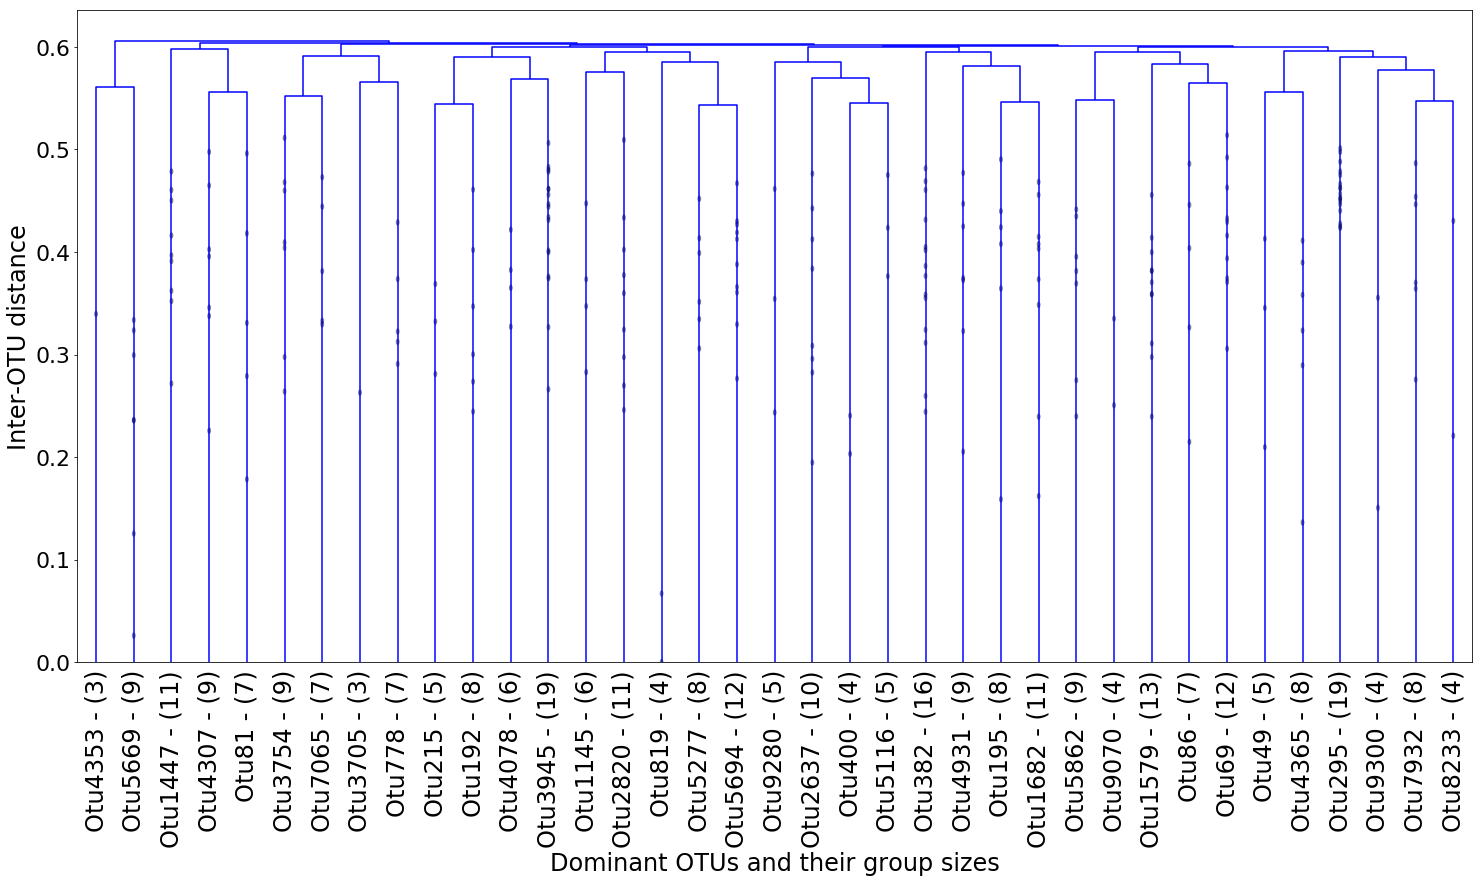

In [33]:
linked = hierarchy.linkage(p_dist_compressed, 'average')

labels = closest_OTUs
p = len(labels)

plt.figure(figsize=(25,12))
#plt.title('Truncated dendrogram with 35 groups', fontsize=20)
plt.xlabel('Dominant OTUs and their group sizes', fontsize=24)
plt.ylabel('Inter-OTU distance', fontsize=24)
plt.yticks(fontsize=22)

# call dendrogram to get the returned dictionary 
# (plotting parameters can be ignored at this point)
R = hierarchy.dendrogram(
                linked,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=p,  # show only the last p merged clusters
                no_plot=True,
                )

print("values passed to leaf_label_func\nleaves : ", R["leaves"])

# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{} - custom label!".format(temp[xx])

# This version gives you your label AND the count
temp = {R["leaves"][ii]:(labels[ii], R["ivl"][ii]) for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{} - {}".format(*temp[xx])

plt_dendro = hierarchy.dendrogram(
            linked,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            leaf_label_func=llf,
            leaf_rotation=90.,
            leaf_font_size=24.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )


### Step 2.1.1: UPGMA Dendrogram with abundance heatmap

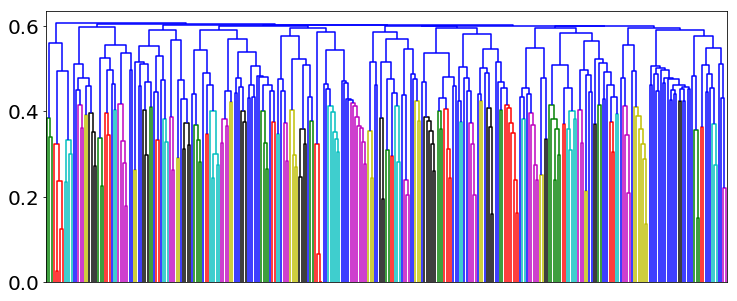

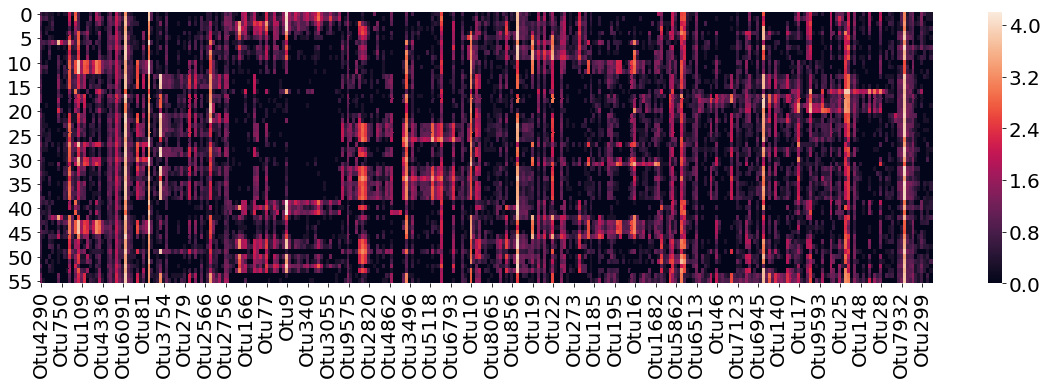

In [34]:
# Rearrange OTU data matrix according to dendrogram order above
df_log10_orig = df_log10.loc[:,'Otu8':'Otu819']
df_log10_ordered = df_log10_orig[OTU_order]

# Create heatmap based on log10 abundance counts
plt.figure(figsize=(12.2,5))
hierarchy.dendrogram(p_clustering_matrix,no_labels=True)
plt.figure(figsize=(20,5))
sns.heatmap(df_log10_ordered)

### Step 2.1.2: UPGMA Dendrogram with association-distance heatmap

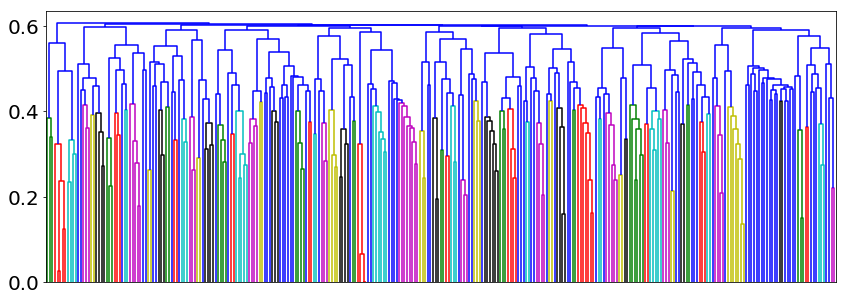

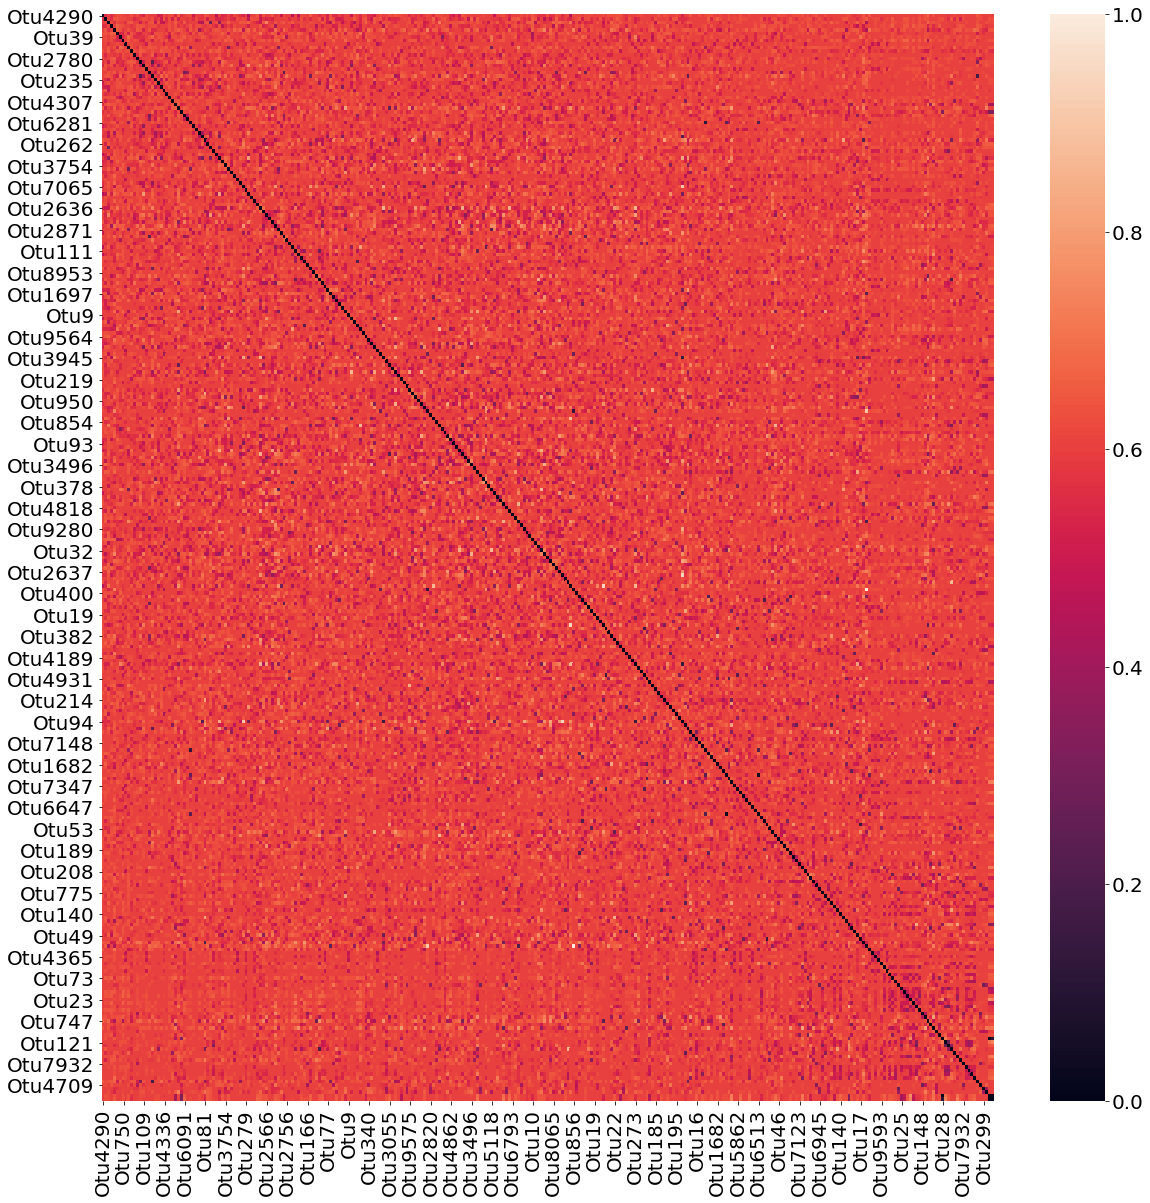

In [35]:
# Create heatmap based on netassoc association-distances
# Recall that association distance = max(association) - association
netassoc_dist_df = pd.DataFrame(data = netassoc_dist, columns = OTU_order, index = OTU_order)

plt.figure(figsize=(14.15,5))
hierarchy.dendrogram(p_clustering_matrix,no_labels=True)

plt.figure(figsize=(20,20))
sns.heatmap(netassoc_dist_df, vmin=0, vmax=1)

### Step 2.1.3: Dendrogram with cluster-number heatmap

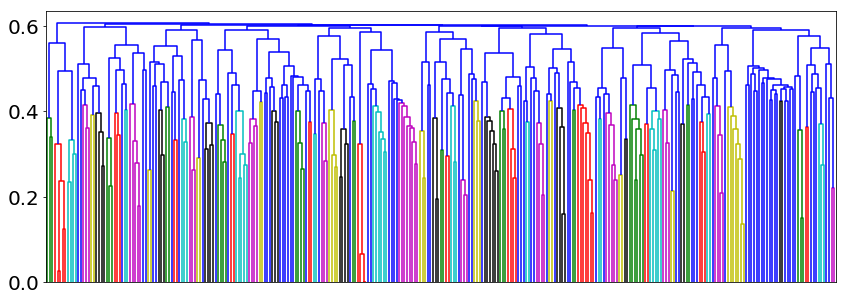

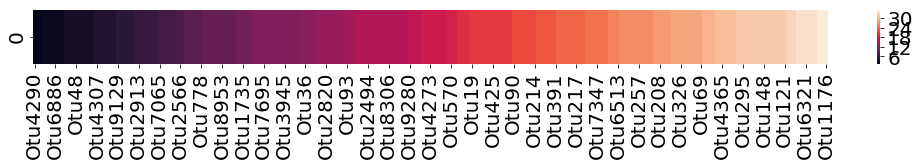

In [36]:
# Grab clustering labels according to UPGMA dendrogram built previously
num_clusters_UPGMA = 35 # Optimal number of clusters
cluster_final_UPGMA = hierarchy.fcluster(p_clustering_matrix, num_clusters_UPGMA, criterion="maxclust")

# Match each OTU to its corresponding cluster
cluster_df_UPGMA = pd.DataFrame(data = cluster_final_UPGMA.reshape(1,-1),columns = OTU_columns.reshape(-1))
cluster_df_UPGMA_ordered = cluster_df_UPGMA[OTU_order]

# Make dendrogram with heatmap
plt.figure(figsize=(14.15,5))
hierarchy.dendrogram(p_clustering_matrix,no_labels=True)

plt.figure(figsize=(17.8,1))
sns.heatmap(cluster_df_UPGMA_ordered)

### Step 2.1.4: Silhouette analysis to find optimal number of UPGMA clusters

In [37]:
# Export some files:
#np.save('square_dist.npy', df_pvalues_dist, allow_pickle=True, fix_imports=True) # Square distance matrix

In [38]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Pick "best" clustering based on Silhouette analysis
num_clusters_max = 100
sil_labels = np.linspace(2,num_clusters_max,num_clusters_max-1)
sil_labels = np.reshape(sil_labels,(-1,1))
sil_avg = np.zeros((num_clusters_max-1,1))
for num_clusters in range(2,num_clusters_max+1):
    cluster_nodes = hierarchy.fcluster(p_clustering_matrix, num_clusters, criterion="maxclust")
    sil_avg_single = silhouette_score(netassoc_dist , cluster_nodes, metric='euclidean')
    sil_avg[num_clusters-2] = sil_avg_single

sil_avg = np.append(sil_labels,sil_avg,axis=1)

Text(0.5, 1.0, 'Silhouette analysis to determine optimal number of UPGMA clusters')

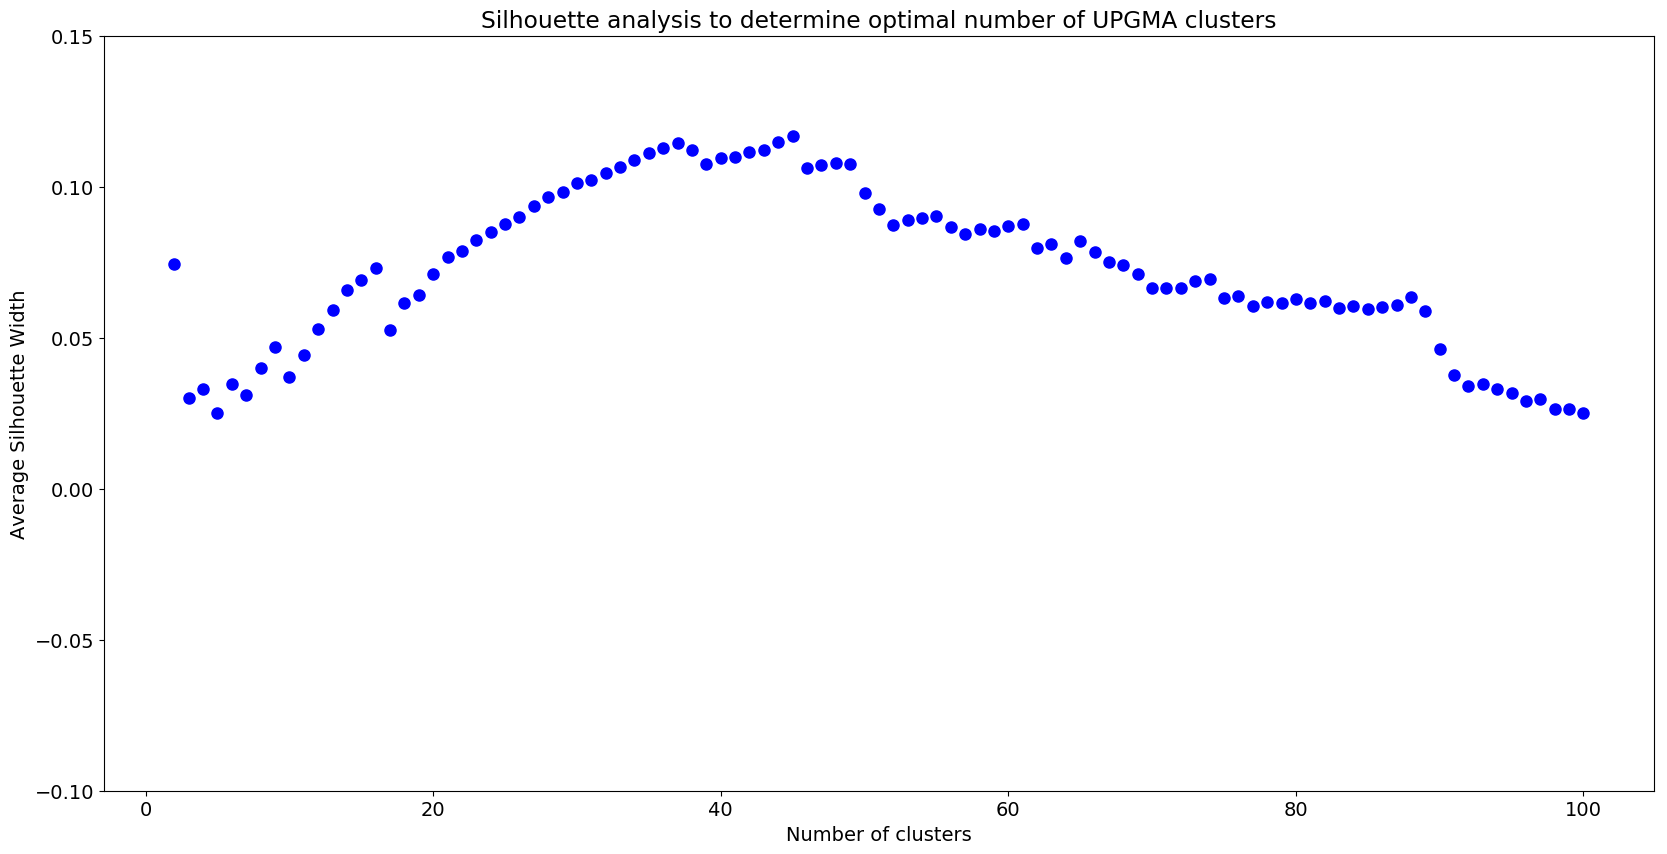

In [39]:
# Plot average Silhouette widths as function of number of clusters:
fig = plt.figure(figsize=(20,10), dpi=100)
plt.rc("font", size=14)
plt.plot(sil_avg[:,0],sil_avg[:,1],'.',markersize=16,color='blue')
plt.ylim(-0.1,0.15)
plt.xlabel("Number of clusters")
plt.ylabel("Average Silhouette Width")
plt.title("Silhouette analysis to determine optimal number of UPGMA clusters")

In [40]:
# Re-do UPGMA clustering based on optimal number of UPGMA clusters:
num_clusters_UPGMA = np.argmax(sil_avg[:,1])+2
cluster_final_UPGMA = hierarchy.fcluster(p_clustering_matrix, num_clusters_UPGMA, criterion="maxclust")
cluster_final_UPGMA

array([ 8,  5, 12, 44, 39,  7,  3, 24, 42,  2, 28, 39, 22,  6, 10, 42, 34,
        6, 39, 25, 12, 41, 39,  3, 30, 14,  4, 21, 34, 34,  2, 10, 33, 39,
       12, 45,  5, 12, 42,  9, 12, 44, 18,  2, 20, 29, 42, 32, 11, 42,  8,
       32, 42, 41, 20, 44,  1, 39, 38, 35,  2,  8, 34,  3, 36,  8, 26,  8,
       27, 37, 22,  5, 33, 24, 25, 35, 42, 12, 40, 18, 11, 30, 12,  1, 42,
       18, 40, 37, 44,  3, 28, 19, 18, 10, 42, 41, 44, 23,  4, 32,  6, 36,
       26, 33, 23, 32, 36, 18, 33,  9, 11, 41, 23, 18, 29,  5,  3,  3, 26,
       44, 20, 32,  8,  4, 37,  5, 10, 29, 26, 23, 39,  8, 33,  2,  9, 37,
       39, 45, 23,  8, 42, 34, 40, 22, 39, 36, 39,  3, 41, 37, 43,  5, 36,
       31, 44, 34, 37, 38, 19, 31,  8, 41, 22, 27, 31, 34, 40, 29, 33, 43,
        3, 24, 33, 36, 34, 35,  7, 28, 23, 20,  3, 42, 43, 24, 36, 33, 36,
       17, 31, 41, 28, 19, 26, 13, 20,  3, 41, 33, 43, 30,  6, 26, 42, 15,
       36, 14,  2, 27, 31, 42, 36, 37, 14,  2, 36, 26, 42, 33, 45, 32, 33,
       15, 42, 31,  2, 16

In [41]:
# Re-do UPGMA clustering based on a specified number of UPGMA clusters:
num_clusters_UPGMA = 9 # Based on previous plot
cluster_final_UPGMA = hierarchy.fcluster(p_clustering_matrix, num_clusters_UPGMA, criterion="maxclust")
cluster_final_UPGMA

array([3, 2, 3, 9, 8, 2, 2, 6, 9, 1, 6, 8, 5, 2, 3, 9, 8, 2, 8, 6, 3, 9,
       8, 2, 7, 4, 2, 5, 8, 8, 1, 3, 7, 8, 3, 9, 2, 3, 9, 3, 3, 9, 5, 1,
       5, 7, 9, 7, 3, 9, 3, 7, 9, 9, 5, 9, 1, 8, 8, 8, 1, 3, 8, 2, 8, 3,
       6, 3, 6, 8, 5, 2, 7, 6, 6, 8, 9, 3, 9, 5, 3, 7, 3, 1, 9, 5, 9, 8,
       9, 2, 6, 5, 5, 3, 9, 9, 9, 5, 2, 7, 2, 8, 6, 7, 5, 7, 8, 5, 7, 3,
       3, 9, 5, 5, 7, 2, 2, 2, 6, 9, 5, 7, 3, 2, 8, 2, 3, 7, 6, 5, 8, 3,
       7, 1, 3, 8, 8, 9, 5, 3, 9, 8, 9, 5, 8, 8, 8, 2, 9, 8, 9, 2, 8, 7,
       9, 8, 8, 8, 5, 7, 3, 9, 5, 6, 7, 8, 9, 7, 7, 9, 2, 6, 7, 8, 8, 8,
       2, 6, 5, 5, 2, 9, 9, 6, 8, 7, 8, 4, 7, 9, 6, 5, 6, 4, 5, 2, 9, 7,
       9, 7, 2, 6, 9, 4, 8, 4, 1, 6, 7, 9, 8, 8, 4, 1, 8, 6, 9, 7, 9, 7,
       7, 4, 9, 7, 1, 4, 7, 7, 7, 8, 1, 7, 8, 8, 7, 6, 7, 7, 4, 4, 9, 4,
       4, 7, 5, 5, 4, 7, 5, 7, 4, 5, 4, 2, 8, 4, 4, 5, 9, 7, 9, 9, 1, 9,
       4, 9, 7, 4, 9, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 4, 5, 5,
       4, 5, 4, 4, 6, 7, 4, 7, 5, 4, 4, 4, 4, 2, 5,

## Step 2.2: Agglomerative Clustering using WARD

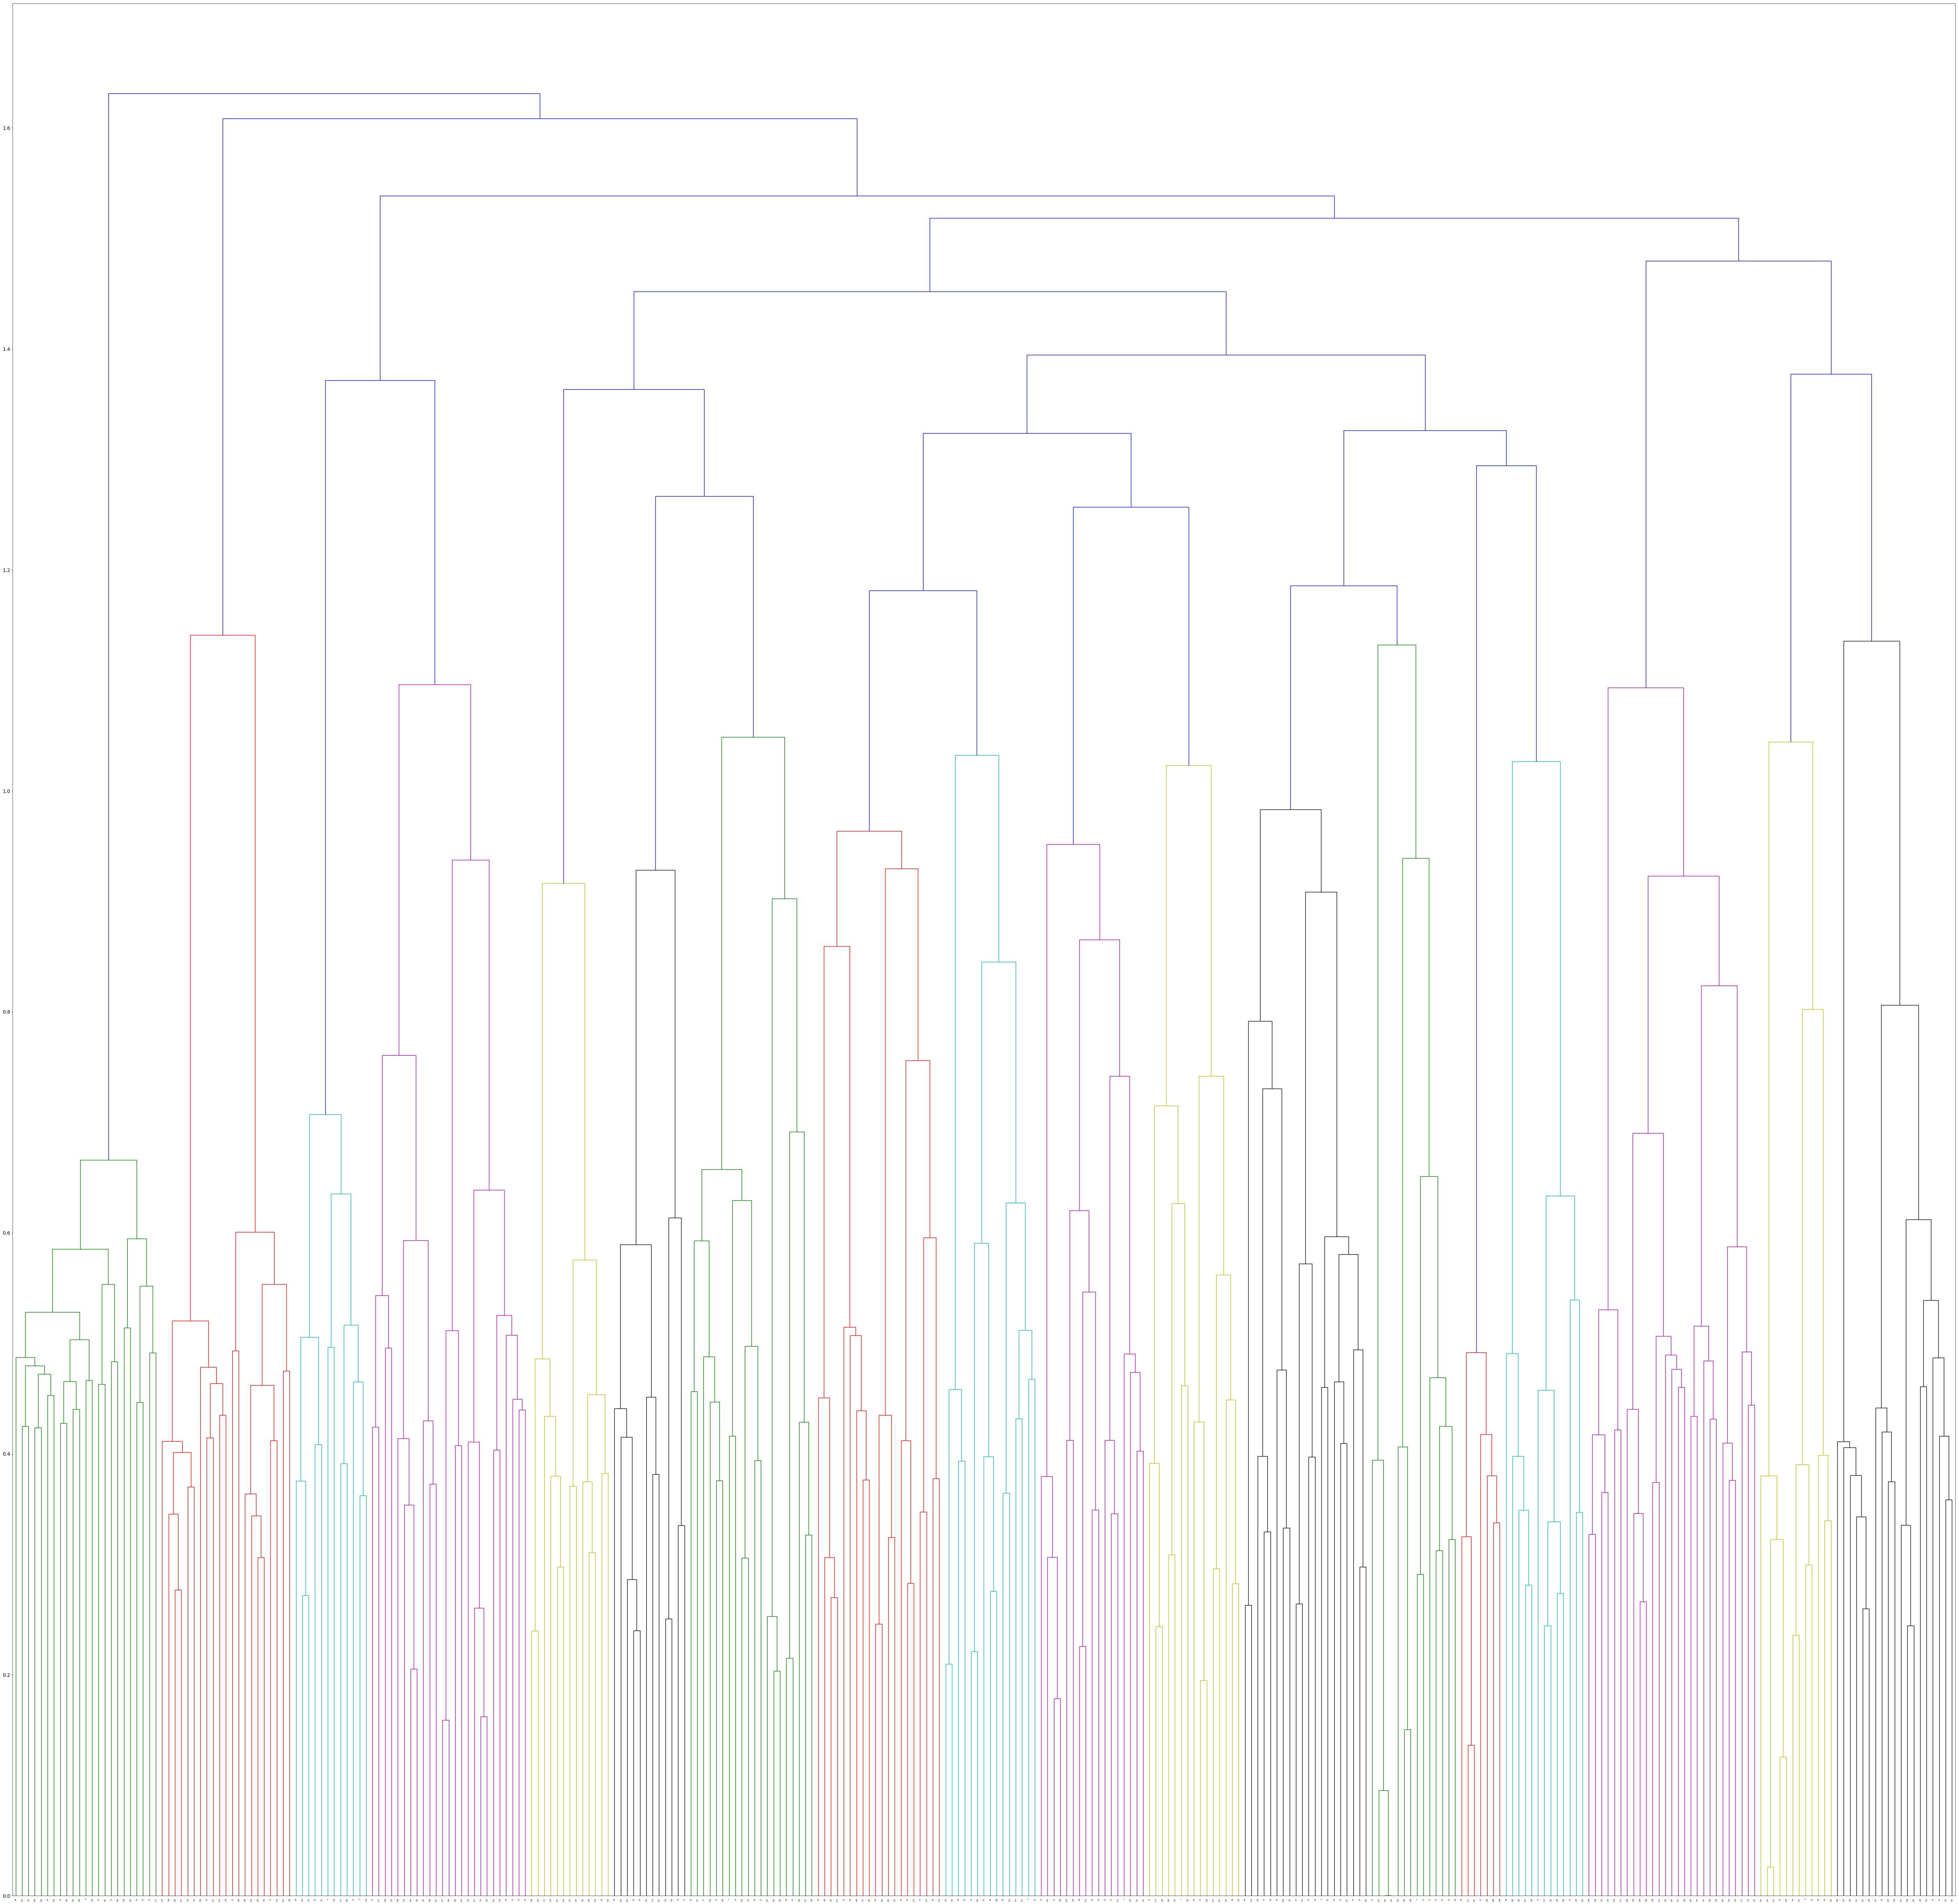

In [42]:
# Perform clustering using WARD analysis (instead of UPGMA)
plt.figure(figsize=(100,100))
#p_clustering_matrix_ward = hierarchy.ward(p_dist_compressed)
p_clustering_matrix_ward = hierarchy.linkage(p_dist_compressed,method='ward')
p_dn = hierarchy.dendrogram(p_clustering_matrix_ward)

## Step 2.3: Agglomerative clustering using Single Linkage

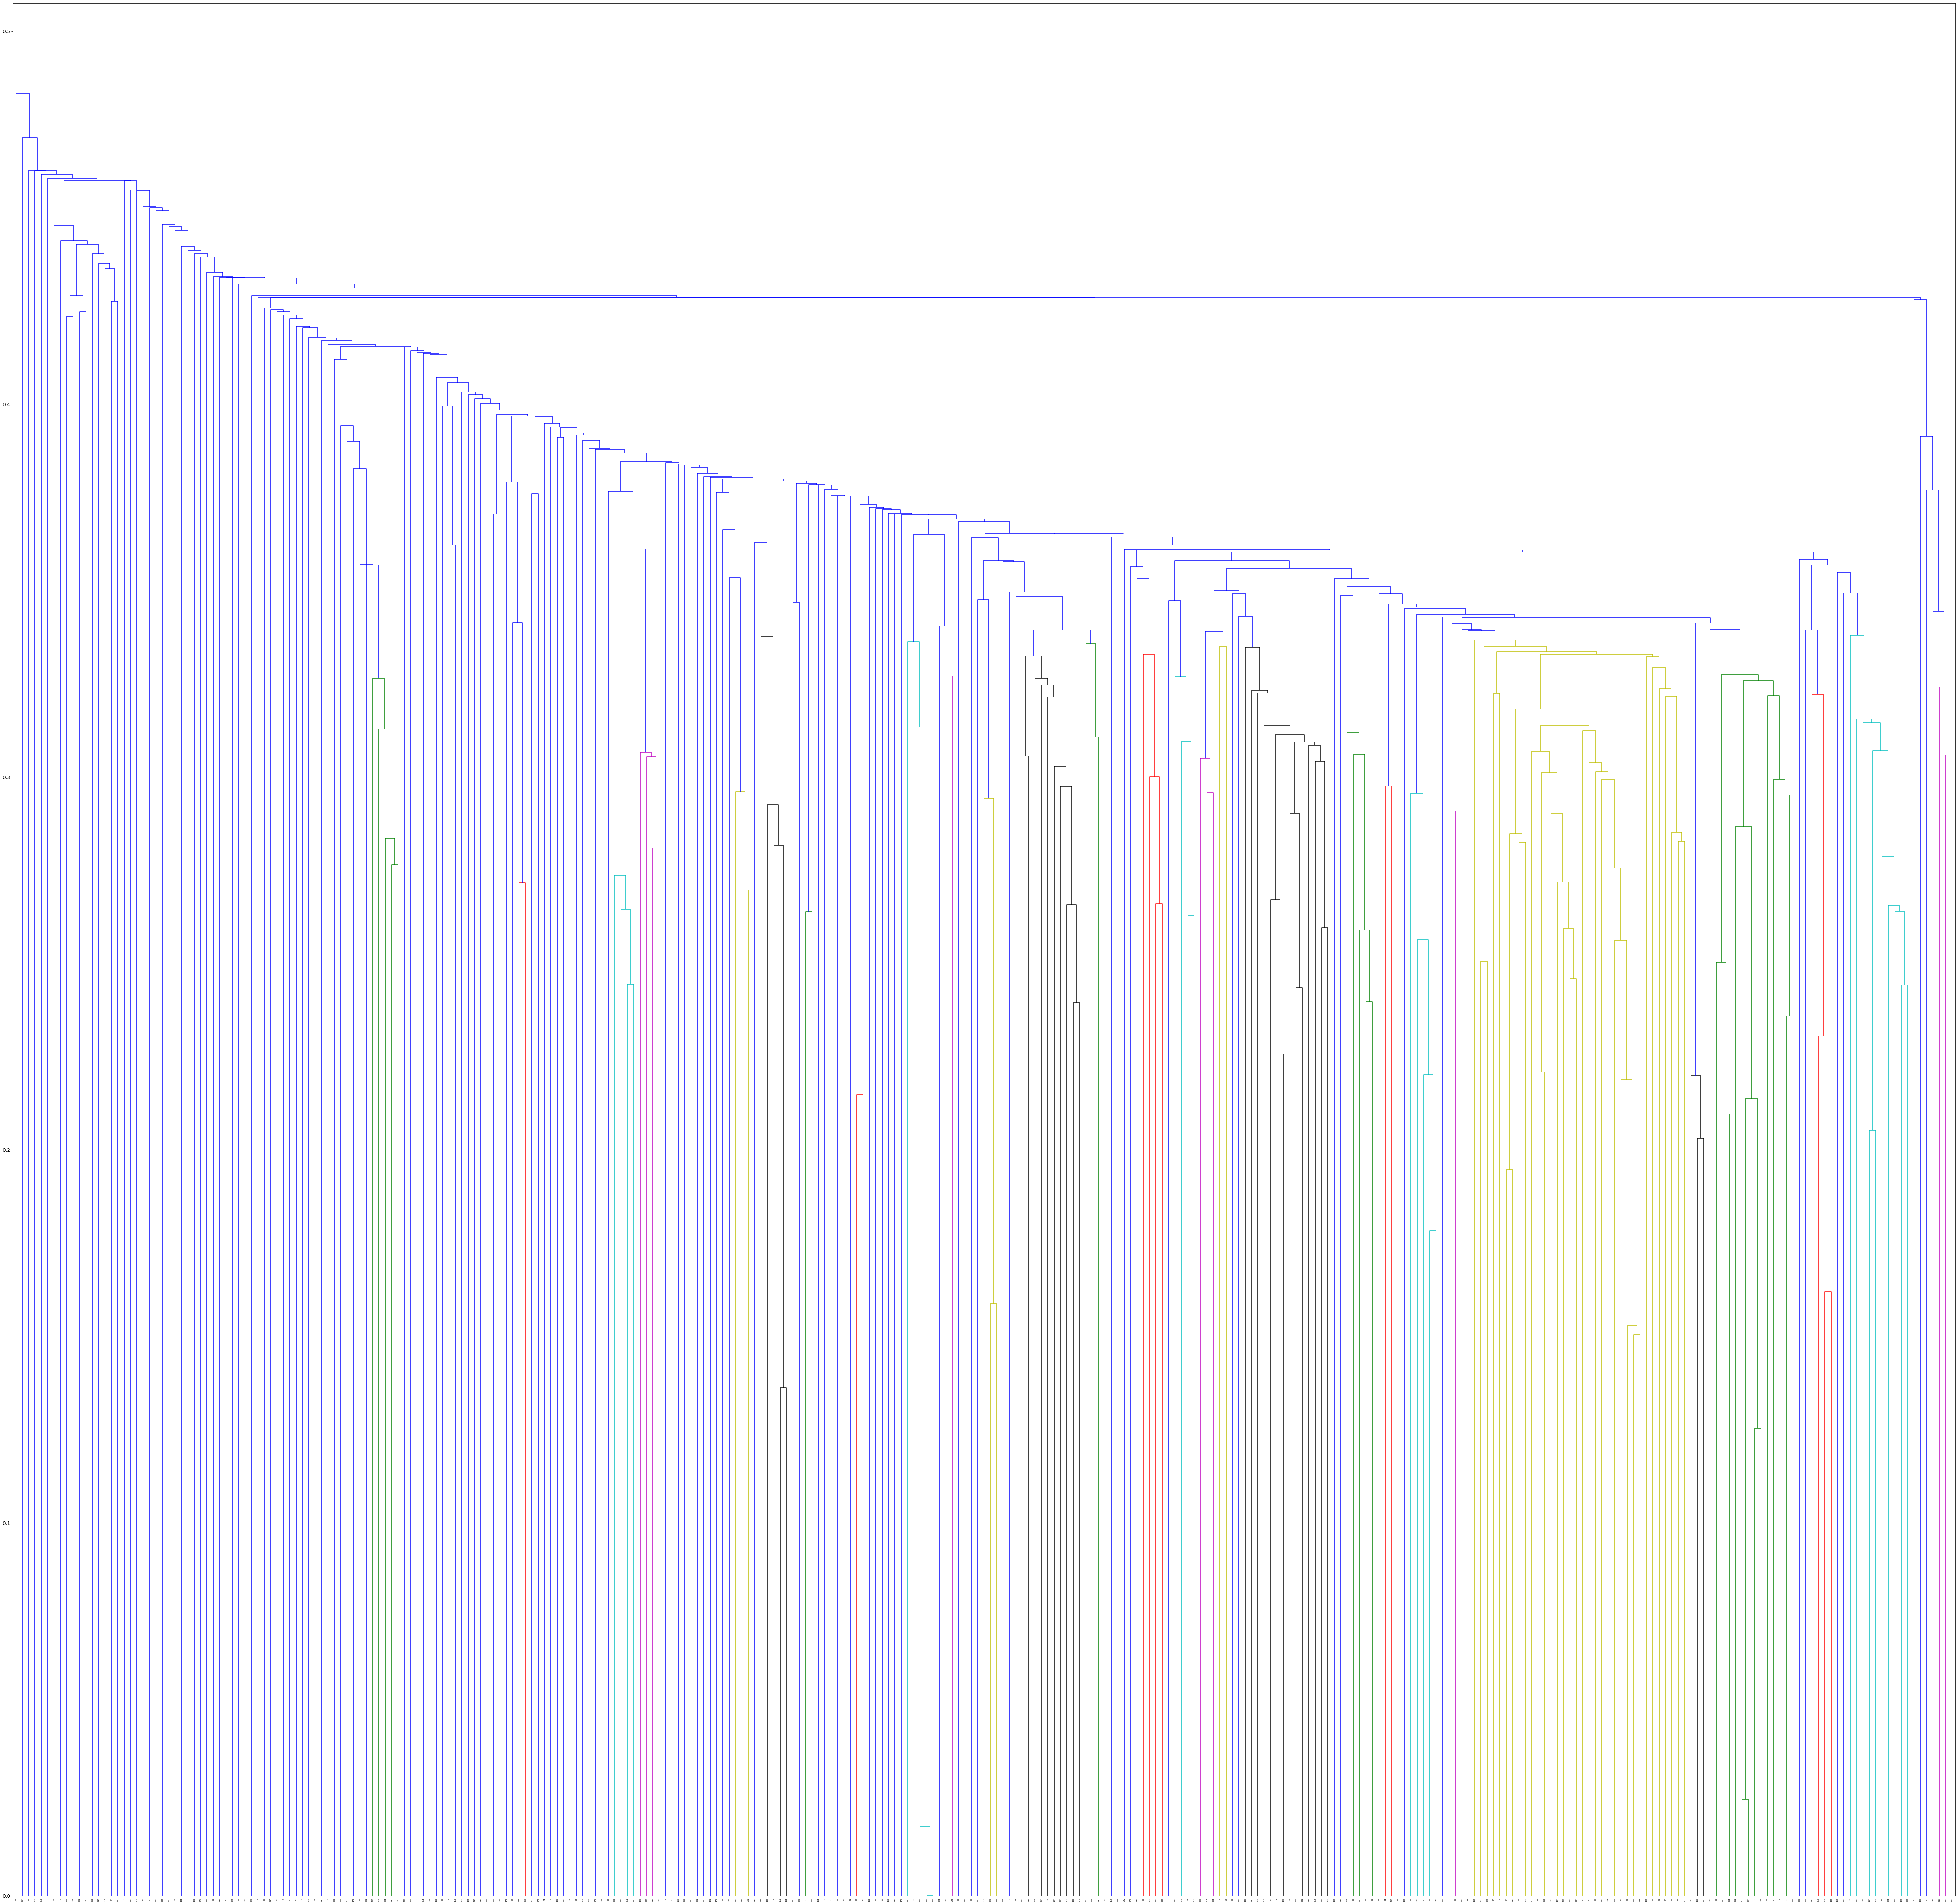

In [43]:
# Perform clustering using single linkage
plt.figure(figsize=(100,100))
#p_clustering_matrix_ward = hierarchy.ward(p_dist_compressed)
p_clustering_matrix_single = hierarchy.linkage(p_dist_compressed,method='single')
p_dn = hierarchy.dendrogram(p_clustering_matrix_single)

## Step 2.4: Agglomerative clustering using Complete Linkage

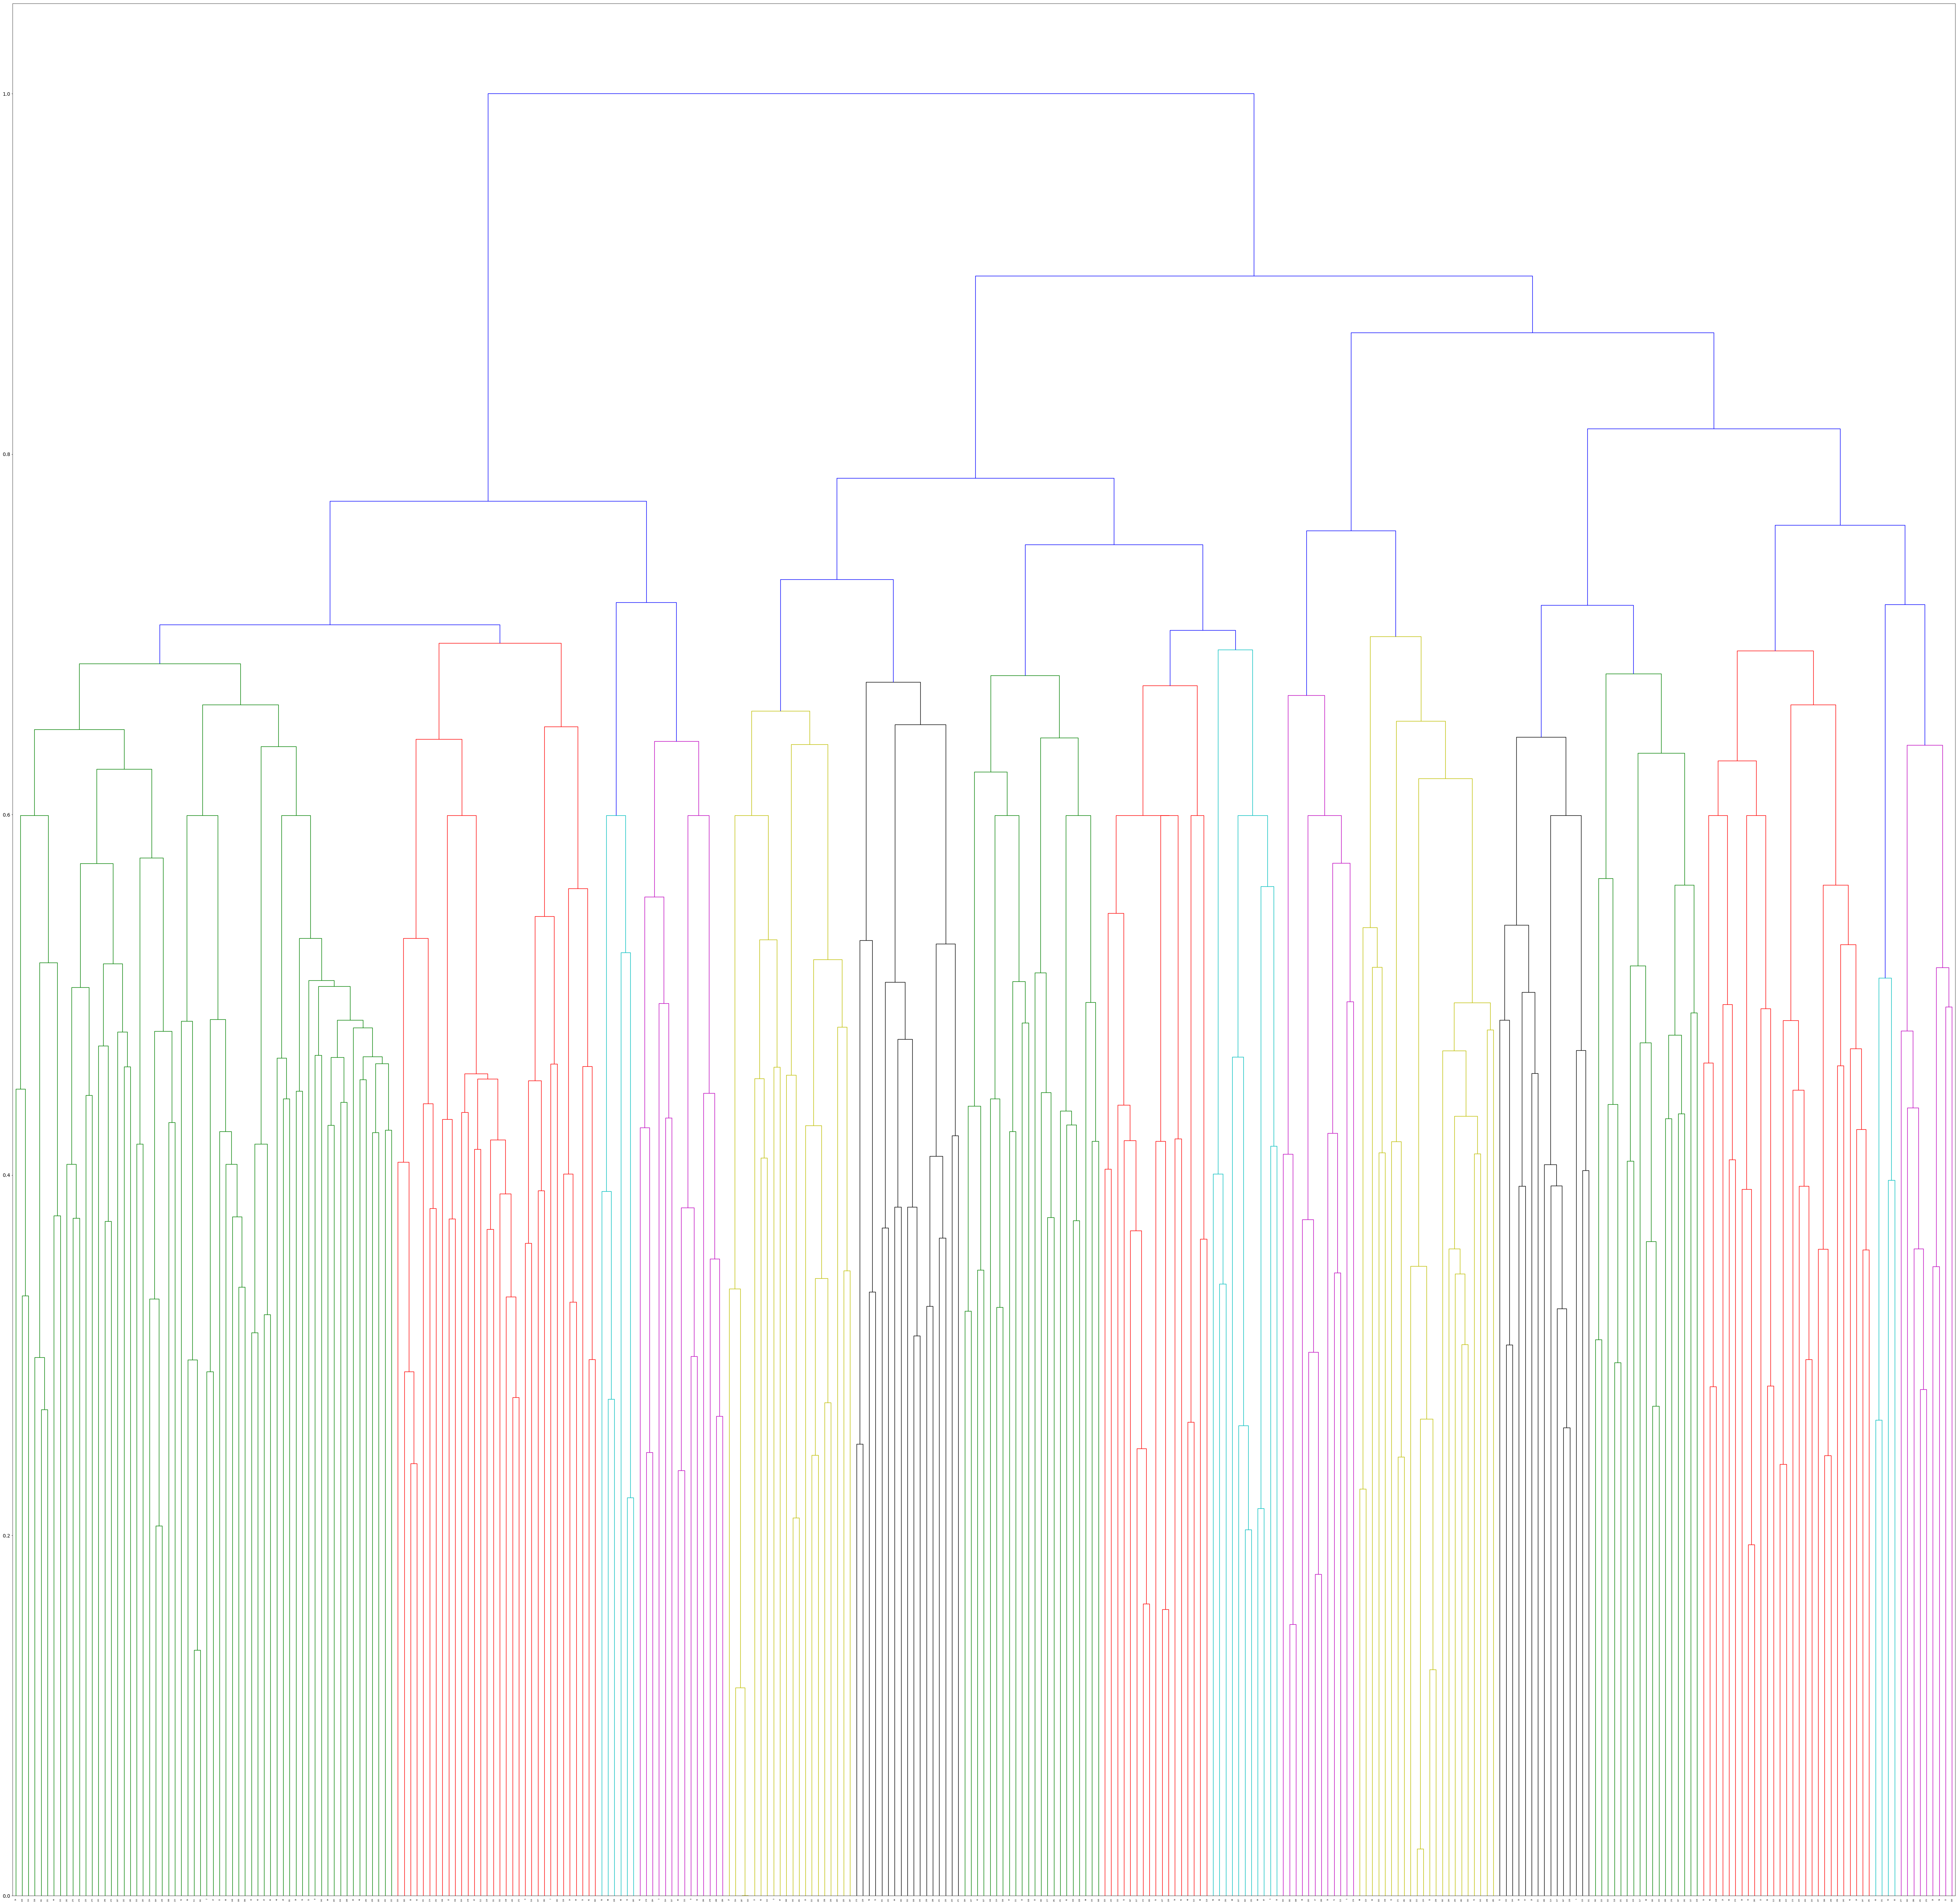

In [44]:
# Perform clustering using complete linkage
plt.figure(figsize=(100,100))
p_clustering_matrix_complete = hierarchy.linkage(p_dist_compressed,method='complete')
p_dn = hierarchy.dendrogram(p_clustering_matrix_complete)

# Step 3: Perform cophenetic correlation analysis to determine "best" clustering method

In [45]:
# Cophenetic correlation analysis
# First un-compress the original compressed distance matrix:
p_dist_uncompressed = squareform(p_dist_compressed)

In [52]:
# Pearson's r-correlation between uncompressed raw distances and cophenetic distances:
[coph_average_corr,coph_average] = hierarchy.cophenet(p_clustering_matrix,p_dist_compressed)
[coph_ward_corr,coph_ward] = hierarchy.cophenet(p_clustering_matrix_ward,p_dist_compressed)
[coph_single_corr,coph_single] = hierarchy.cophenet(p_clustering_matrix_single,p_dist_compressed)
[coph_complete_corr,coph_complete] = hierarchy.cophenet(p_clustering_matrix_complete,p_dist_compressed)

In [53]:
# Print Cophenetic correlations for each clustering method, and compare:
print("Cophenetic correlation for UPGMA clustering is {:0.3f}".format(coph_average_corr))
print("Cophenetic correlation for WARD clustering is {:0.3f}".format(coph_ward_corr))
print("Cophenetic correlation for single-linkage clustering is {:0.3f}".format(coph_single_corr))
print("Cophenetic correlation for complete-linkage clustering is {:0.3f}".format(coph_complete_corr))

Cophenetic correlation for UPGMA clustering is 0.512
Cophenetic correlation for WARD clustering is 0.413
Cophenetic correlation for single-linkage clustering is 0.075
Cophenetic correlation for complete-linkage clustering is 0.216


In [54]:
# Print best clustering method
coph_corr_values = np.array((coph_average_corr,coph_ward_corr,coph_single_corr,coph_complete_corr))
clustering_types = ['UPGMA','WARD','SINGLE','COMPLETE']

print("According to Cophenetic correlations, the best clustering method is {}.".format(clustering_types[np.argmax(coph_corr_values)]))

According to Cophenetic correlations, the best clustering method is UPGMA.
